In [1]:
import sys
path = "/Users/usuario/git/sisepuede"
if not path in sys.path:
    sys.path.append(path)
    
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import time
from typing import *
import warnings
warnings.filterwarnings("ignore")


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as sup
import sisepuede.utilities._toolbox as sf

# temporary fix to avoid rebuilding logger everytime
log_job = None

In [2]:
##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_transformations = dir_cur.joinpath("transformations")


##  SETUP FILES

fp_data_base = dir_data.joinpath("real_data_TZA_PER_LKA_20250210.csv")
#fp_data_modified = dir_data.joinpath("sisepuede_inputs_iran_modified.csv")


##  SETUP SOME SISEPUEDE STUFF

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

In [107]:
##  BUILD BASE INPUTS

df_inputs = pd.read_csv(fp_data_base)
df_inputs["frac_gnrl_eating_red_meat"] = 1
df_inputs["lndu_reallocation_factor"] = 1

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame



# add years/time periods
df_inputs = regions.add_region_or_iso_field(
    df_inputs,
    field_iso = "iso_code3",
)

df_inputs = time_periods.years_to_tps(
    df_inputs,
    field_year = "Year",
)

df_inputs.drop(
    columns = ["iso_code3", "Year"],
    inplace = True,
)

fields_overwrite = [
    x for x in df_inputs_example.columns 
    if (x not in df_inputs.columns)
    and (x not in matt.sort_ordered_dimensions_of_analysis)
]

for field in fields_overwrite:
    if field in df_inputs.columns:
        continue
    
    df_inputs[field] = df_inputs_example[field]


##  SOME REPLACEMENTS

fields_skip_from_modvars = [
    'cost_enfu_fuel_ammonia_usd_per_tonne',
     'ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia',
     'ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia',
     'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia',
     'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia',
     'exports_enfu_pj_fuel_ammonia',
     'frac_enfu_fuel_demand_imported_pj_fuel_ammonia',
     'nemomod_entc_capital_cost_fp_ammonia_production_mm_usd_per_gw',
     'nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw',
     'nemomod_entc_emissions_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_tonne_co2_per_tj',
     'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2',
     'nemomod_entc_fixed_cost_fp_ammonia_production_mm_usd_per_gw',
     'nemomod_entc_fixed_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw',
     'nemomod_entc_grid_power_constraint_mmm_usd',
     'nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_electricity',
     'nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_hydrogen',
     'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water',
     'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity',
     'energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia',
     'energydensity_gravimetric_enfu_gj_per_tonne_fuel_water',
     'frac_trns_fuelmix_water_borne_ammonia',
     'nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia',
     'nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen',
     'nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs',
     'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas',
     'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil'
]

def replace_some_values_from_full(
    df_in: pd.DataFrame,
    df_example: pd.DataFrame,
    model_attributes: 'ModelAttributes',
    fields_skip_from_modvars: Union[List[str], None] = None,
) -> pd.DataFrame:
    """Many values are missing from the inputs for tanzania

    Function Arguments
    ------------------
    df_in : pd.DataFrame
        DataFrame to copy values into
    df_example : pd.DataFrame
        DataFrame to copy values from
    model_attriubtes : ModelAttributes
        Object used to access model variables, field indices, etc.
    
    Keyword Arguments
    -----------------
    fields_skip_from_modvars : Union[List[str], None]
        Optional fields to specify as copying WITHOUT requiring entire model
        variables to be copied over. Only specify if you know some fields 
        have been added to data and can be added safely (e.g., simplex fractions 
        that don't exceed 0)
    """

    fields_skip_from_modvars = (
        [] 
        if not isinstance(fields_skip_from_modvars, list) 
        else [
            x for x in fields_skip_from_modvars
            if x in df_example.columns
        ]
    )
    
    fields = [
        x for x in df_in.columns if 
        (len(df_in[x].dropna()) < df_in.shape[0])
        and (x not in fields_skip_from_modvars)
    ]
    
    if len(fields + fields_skip_from_modvars) == 0:
        
        return df_in


    modvars = set(
        model_attributes.dict_variable_fields_to_model_variables.get(x)
        for x in fields
    )

    fields_copy = sum(
        [
            matt.get_variable(x).fields for x in modvars
            if matt.get_variable(x) is not None
        ],
        []
    )

    fields_copy += fields_skip_from_modvars
    for field in fields_copy:
        df_in[field] = df_example[field].to_numpy().copy()

        if len(df_in[field].dropna()) != df_in.shape[0]:
            raise RuntimeError(f"\t here there's a problem with field {field}!")

    return df_in



def replace_some_values(
    df_inputs: pd.DataFrame,
    df_example: pd.DataFrame,
    model_attributes: 'ModelAttributes',
    **kwargs,
) -> pd.DataFrame:
    """Many values are missing from the inputs for some countries, so here, make those replacements

    Function Arguments
    ------------------
    df_in : pd.DataFrame
        DataFrame to copy values into
    df_example : pd.DataFrame
        DataFrame to copy values from
    model_attriubtes : ModelAttributes
        Object used to access model variables, field indices, etc.
    
    Keyword Arguments
    -----------------
    fields_skip_from_modvars : Union[List[str], None]
        Optional fields to specify as copying WITHOUT requiring entire model
        variables to be copied over. Only specify if you know some fields 
        have been added to data and can be added safely (e.g., simplex fractions 
        that don't exceed 0)
    """

    dfg = df_inputs.groupby([model_attributes.dim_region])
    df_out = []
    
    for tup, df in dfg:
        
        df = replace_some_values_from_full(
            df,
            df_example,
            model_attributes,
            **kwargs
        )
        

        df_out.append(df)

    out = (
        pd.concat(df_out)
        .reset_index(drop = True, )
    )

    return out




if True:
    df_inputs = replace_some_values(
        df_inputs,
        df_inputs_example,
        matt,
        fields_skip_from_modvars = fields_skip_from_modvars,
    )

#  Let's try building transformations using this


In [109]:
import sisepuede.transformers.transformers as trf2
importlib.reload(trf2)
transformers = trf2.Transformers(
    {},
    df_input = df_inputs,
)


"""
tr_run = transformations.get_transformation("TX:ENTC:TARGET_RENEWABLE_ELEC_LOWER")
df = tr_run()
 df[[x for x in df.columns if ("min_share" in x) & ("_pp_" in x)]].tail()
""";

##  Instantiate some transformations CAREFUL NOT TO OVERWRITE EXISTING TRANSFORMATIONS!!

In [110]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--
- go to `dir_transformers` and edit config files and `strategy_definitions.csv`
- then, go to next cell

In [111]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table


In [121]:
#  build the strategies -- will export to path
t0 = time.time()
import sisepuede.transformers.strategies as trfs
importlib.reload(trfs)
strategies = trfs.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

# build whirlpool with existing data
# tss = strategies.build_whirlpool_strategies(6004, ids = list(range(7101, 7160)))

Strategies defined at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/transformations initialized in 2.99 seconds


In [42]:
tab = strategies.attribute_table.table
tab[tab["strategy_id"].isin([1009])]

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
10,1009,LNDU:PLUR,Singleton - Default Value - LNDU: Partial land...,NaN,TX:LNDU:PLUR,0


##  Build our templates
- let's use the default variable groupings for LHS

In [170]:
df_vargroups = examples("variable_trajectory_group_specification")

importlib.reload(trfs)
strategies = trfs.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = [0, 1009],#strategies.all_strategies,#list(range(7101, 7160)),#[0, 6003, 6004, 6005] #+ list(range(7001, 7062)), # list(range(7101, 7160))
)



starting strat 1009 with input shape (36, 2260)
strat 1009 with output shape (36, 2260)
here = 1009
starting strat 1009 with input shape (36, 2260)
strat 1009 with output shape (36, 2260)
here = 1009
starting strat 1009 with input shape (36, 2260)
strat 1009 with output shape (36, 2260)
here = 1009


0

# Finally, load SISEPUEDE so that we can run it

In [171]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    #id_str = "sisepuede_run_2024-12-04T13:28:29.811153",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    logger = log_job,
    regions = ["peru", "sri_lanka", "united_republic_of_tanzania"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)
log_job = ssp.logger


2025-02-19 11:07:51,599 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-02-19 11:07:51,601 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-02-19 11:07:51,601 - INFO - 	Setting export engine to 'csv'.
2025-02-19 11:07:51,602 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-02-19 11:07:51,602 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-02-19 11:07:51,602 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-02-19 11:07:51,602 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-02-19 11:07:51,603 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-02-19 11:07:51,603 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-02-19 11:07:51,603 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod
        Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
2025-02-19 11:08:57,686 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-02-19 11:08:57,701 - INFO - Successfully initialized SISEPUEDEModels.
2025-02-19 11:08:57,708 - INFO - Table ANALYSIS_METADATA successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-02-19T11;07;51.247002/sisepuede_run_2025-02-19T11;07;51.247002_output_database/ANALYSIS_METADATA.csv.
2025-02-19 11:08:57

In [172]:

# run HEREHERE
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: [1009],#list(range(7101, 7160)),#[0, 6003, 6004, 6005],#list(range(7001, 7062)),#
}

#prim_run = [179179]
ssp.project_scenarios(
    dict_scens,
    check_results = False, # spikes
    save_inputs = True,
)


2025-02-19 11:11:16,652 - INFO - 
***	STARTING REGION peru	***

2025-02-19 11:11:18,291 - INFO - Trying run primary_id = 10010 in region peru
2025-02-19 11:11:18,292 - INFO - Running AFOLU model
2025-02-19 11:11:18,403 - INFO - AFOLU model run successfully completed
2025-02-19 11:11:18,404 - INFO - Running CircularEconomy model
2025-02-19 11:11:18,432 - INFO - CircularEconomy model run successfully completed
2025-02-19 11:11:18,432 - INFO - Running IPPU model
2025-02-19 11:11:18,477 - INFO - IPPU model run successfully completed
2025-02-19 11:11:18,477 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-02-19 11:11:18,489 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-02-19 11:11:18,541 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-02-19 11:11:18,542 - INFO - Running Energy model (Electricity and Fuel Production: trying t

2025-19-Feb 11:11:18.844 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-19-Feb 11:11:18.963 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-19-Feb 11:11:28.112 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-02-19 11:11:58,606 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-02-19 11:11:58,612 - INFO - EnergyProduction model run successfully completed
2025-02-19 11:11:58,612 - INFO - Running Energy (Fugitive Emissions)
2025-02-19 11:11:58,632 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-02-19 11:11:58,632 - INFO - Appending Socioeconomic outputs
2025-02-19 11:11:58,636 - INFO - Socioeconomic outputs successfully appended.
2025-02-19 11:11:58,637 - INFO - Model run for primary_id = 10010 successfully completed in 40.35 seconds (n_tries = 1).
2025-02-19 11:11:58,647 - INFO - 
***	 REGION peru COMPLETE	***

2025-02-19 11:11:58,647 - INFO - 
***	STARTING REGION sri_lanka	***



2025-19-Feb 11:11:58.513 Finished modeling scenario.


2025-02-19 11:12:00,199 - INFO - Trying run primary_id = 10010 in region sri_lanka
2025-02-19 11:12:00,200 - INFO - Running AFOLU model
2025-02-19 11:12:00,292 - INFO - AFOLU model run successfully completed
2025-02-19 11:12:00,292 - INFO - Running CircularEconomy model
2025-02-19 11:12:00,316 - INFO - CircularEconomy model run successfully completed
2025-02-19 11:12:00,316 - INFO - Running IPPU model
2025-02-19 11:12:00,356 - INFO - IPPU model run successfully completed
2025-02-19 11:12:00,357 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-02-19 11:12:00,366 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-02-19 11:12:00,413 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-02-19 11:12:00,414 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-19-Feb 11:12:01.019 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-02-19 11:12:46,419 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-02-19 11:12:46,425 - INFO - EnergyProduction model run successfully completed
2025-02-19 11:12:46,426 - INFO - Running Energy (Fugitive Emissions)
2025-02-19 11:12:46,445 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-02-19 11:12:46,445 - INFO - Appending Socioeconomic outputs
2025-02-19 11:12:46,449 - INFO - Socioeconomic outputs successfully appended.
2025-02-19 11:12:46,451 - INFO - Model run for primary_id = 10010 successfully completed in 46.25 seconds (n_tries = 1).
2025-02-19 11:12:46,460 - INFO - 
***	 REGION sri_lanka COMPLETE	***

2025-02-19 11:12:46,460 - INFO - 
***	STARTING REGION united_republic_of_tanzania	***



2025-19-Feb 11:12:46.337 Finished modeling scenario.


2025-02-19 11:12:47,984 - INFO - Trying run primary_id = 10010 in region united_republic_of_tanzania
2025-02-19 11:12:47,984 - INFO - Running AFOLU model
2025-02-19 11:12:48,078 - INFO - AFOLU model run successfully completed
2025-02-19 11:12:48,078 - INFO - Running CircularEconomy model
2025-02-19 11:12:48,102 - INFO - CircularEconomy model run successfully completed
2025-02-19 11:12:48,102 - INFO - Running IPPU model
2025-02-19 11:12:48,142 - INFO - IPPU model run successfully completed
2025-02-19 11:12:48,142 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-02-19 11:12:48,152 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-02-19 11:12:48,186 - ERROR - Error running EnergyConsumption without Fugitive Emissions: Invalid summations found: some categories exceed the sum threshold.Energy fractions by category do not sum to 1. See definition of dict_arrs_trns_frac_fue

{'peru': [10010], 'sri_lanka': [10010], 'united_republic_of_tanzania': [10010]}

In [248]:
dir(ssp.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT"))

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_columns_and_index_on_write',
 '_clean_stash',
 '_destroy',
 '_drop_indices',
 '_initialize_conflict_resolution',
 '_initialize_engine',
 '_initialize_table',
 '_initialize_table_indices',
 '_log',
 '_logger',
 '_stash',
 '_verify_existence',
 '_write_to_table',
 'available_indices',
 'check_table_indices',
 'columns',
 'engine',
 'exists',
 'fields_index',
 'filter_data_frame_from_index_tuples',
 'fp_table',
 'index_conflict_resolution',
 'interaction_type',
 'keep_stash',
 'read_table',
 'resolve_index_conlicts',
 'stash',
 'table_name',
 'valid_resolutions']

['region', 'primary_id']

In [264]:
tab = ssp.database.db.dict_iterative_database_tables.get("MODEL_INPUT")
inds = tab.fields_index.copy()

tab._initialize_table_indices(
    fields_index = inds,
)

2024-12-08 00:09:57,200 - INFO - Successfully initiatlized available indices from CSV at /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2024-12-07T12;18;10.071663/sisepuede_run_2024-12-07T12;18;10.071663_output_database/MODEL_INPUT.csv


In [49]:
prim_all = ssp.get_primary_keys(
    {
        ssp.key_design: [0],
        ssp.key_future: [0],
        ssp.key_strategy: list(range(7101, 7160)),#[0, 6003, 6004, 6005],
    }
)
prim_run = [x for x in prim_all if x not in list(df_out[ssp.key_primary].unique())]
prim_run

[149149, 173173, 179179]

In [17]:
# [149149, 173173, 179179]
prim_run = [179179]
#[x for x in prim_run| if x not in set(df_out[ssp.key_primary].unique())]


In [31]:
ssp.models.model_enerprod.solver_time_limit = 1500
"""
{
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: [6004],#list(range(7001, 7062)),#[0, 6003, 6004, 6005],
}
""";
ssp.project_scenarios(
    prim_run[1:],
    check_results = False,
    
    force_overwrite_existing_primary_keys = True,
    save_inputs = True,
)

2024-12-08 02:30:15,732 - INFO - 
***	STARTING REGION iran	***

2024-12-08 02:30:17,969 - INFO - Trying run primary_id = 149149 in region iran
2024-12-08 02:30:17,969 - INFO - Running AFOLU model
2024-12-08 02:30:18,063 - INFO - AFOLU model run successfully completed
2024-12-08 02:30:18,064 - INFO - Running CircularEconomy model
2024-12-08 02:30:18,089 - INFO - CircularEconomy model run successfully completed
2024-12-08 02:30:18,090 - INFO - Running IPPU model
2024-12-08 02:30:18,133 - INFO - IPPU model run successfully completed
2024-12-08 02:30:18,134 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-12-08 02:30:18,144 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-12-08 02:30:18,194 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-12-08 02:30:18,194 - INFO - Running Energy model (Electricity and Fuel Production: trying 

2024-08-Dec 02:30:18.976 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2024-08-Dec 02:31:07.285 Solver did not find a solution for model. No results will be saved to database.
2024-08-Dec 02:31:07.286 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:31:07,289 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable
2024-12-08 02:31:07,290 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:31:07,302 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2024-12-08 02:31:07,302 - INFO - Appending Socioeconomic outputs
2024-12-08 02:31:07,306 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:31:07,307 - INFO - Model run for primary_id = 149149 successfully completed in 49.34 seconds (n_tries = 1).
2024-12-08 02:31:07,310 - INFO - Trying run primary_id = 150150 in region iran
2024-12-08 02:31:07,310 - INFO - Running AFOLU model
2024-12-08 02:31:07,404 - INFO - AFOLU model run successfully completed
2024-12-08 02:31:0

2024-08-Dec 02:31:08.130 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:32:10,549 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:32:10,556 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:32:10,556 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:32:10,578 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:32:10,579 - INFO - Appending Socioeconomic outputs
2024-12-08 02:32:10,584 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:32:10,585 - INFO - Model run for primary_id = 150150 successfully completed in 63.28 seconds (n_tries = 1).
2024-12-08 02:32:10,588 - INFO - Trying run primary_id = 152152 in region iran
2024-12-08 02:32:10,588 - INFO - Running AFOLU model


2024-08-Dec 02:32:10.463 Finished modeling scenario.


2024-12-08 02:32:10,686 - INFO - AFOLU model run successfully completed
2024-12-08 02:32:10,686 - INFO - Running CircularEconomy model
2024-12-08 02:32:10,710 - INFO - CircularEconomy model run successfully completed
2024-12-08 02:32:10,710 - INFO - Running IPPU model
2024-12-08 02:32:10,750 - INFO - IPPU model run successfully completed
2024-12-08 02:32:10,750 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-12-08 02:32:10,760 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-12-08 02:32:10,811 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-12-08 02:32:10,811 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-08-Dec 02:32:11.410 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2024-08-Dec 02:33:20.480 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:33:20,564 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:33:20,570 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:33:20,570 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:33:20,590 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:33:20,590 - INFO - Appending Socioeconomic outputs
2024-12-08 02:33:20,594 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:33:20,595 - INFO - Model run for primary_id = 152152 successfully completed in 70.01 seconds (n_tries = 1).
2024-12-08 02:33:20,598 - INFO - Trying run primary_id = 157157 in region iran
2024-12-08 02:33:20,598 - INFO - Running AFOLU model
2024-12-08 02:33:20,692 - INFO - AFOLU model run successfull

2024-08-Dec 02:33:21.596 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2024-08-Dec 02:34:32.591 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:34:32,675 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:34:32,680 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:34:32,681 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:34:32,700 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:34:32,701 - INFO - Appending Socioeconomic outputs
2024-12-08 02:34:32,705 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:34:32,706 - INFO - Model run for primary_id = 157157 successfully completed in 72.11 seconds (n_tries = 1).
2024-12-08 02:34:32,709 - INFO - Trying run primary_id = 160160 in region iran
2024-12-08 02:34:32,710 - INFO - Running AFOLU model
2024-12-08 02:34:32,806 - INFO - AFOLU model run successfull

2024-08-Dec 02:34:33.539 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:35:41,349 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:35:41,356 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:35:41,356 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:35:41,378 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:35:41,378 - INFO - Appending Socioeconomic outputs
2024-12-08 02:35:41,384 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:35:41,386 - INFO - Model run for primary_id = 160160 successfully completed in 68.68 seconds (n_tries = 1).
2024-12-08 02:35:41,390 - INFO - Trying run primary_id = 173173 in region iran
2024-12-08 02:35:41,391 - INFO - Running AFOLU model


2024-08-Dec 02:35:41.264 Finished modeling scenario.


2024-12-08 02:35:41,491 - INFO - AFOLU model run successfully completed
2024-12-08 02:35:41,492 - INFO - Running CircularEconomy model
2024-12-08 02:35:41,516 - INFO - CircularEconomy model run successfully completed
2024-12-08 02:35:41,516 - INFO - Running IPPU model
2024-12-08 02:35:41,557 - INFO - IPPU model run successfully completed
2024-12-08 02:35:41,557 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-12-08 02:35:41,568 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-12-08 02:35:41,618 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-12-08 02:35:41,618 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-08-Dec 02:35:42.243 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:36:42,551 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable
2024-12-08 02:36:42,553 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:36:42,565 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2024-12-08 02:36:42,565 - INFO - Appending Socioeconomic outputs
2024-12-08 02:36:42,569 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:36:42,570 - INFO - Model run for primary_id = 173173 successfully completed in 61.18 seconds (n_tries = 1).
2024-12-08 02:36:42,574 - INFO - Trying run primary_id = 175175 in region iran
2024-12-08 02:36:42,574 - INFO - Running AFOLU model
2024-12-08 02:36:42,669 - INFO - AFOLU model run successfully completed
2024-12-08 02:36:4

2024-08-Dec 02:36:42.547 Solver did not find a solution for model. No results will be saved to database.
2024-08-Dec 02:36:42.549 Finished modeling scenario.


2024-12-08 02:36:42,797 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-12-08 02:36:42,798 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-08-Dec 02:36:43.565 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:37:51,099 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:37:51,105 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:37:51,105 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:37:51,127 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:37:51,127 - INFO - Appending Socioeconomic outputs
2024-12-08 02:37:51,132 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:37:51,133 - INFO - Model run for primary_id = 175175 successfully completed in 68.56 seconds (n_tries = 1).
2024-12-08 02:37:51,136 - INFO - Trying run primary_id = 176176 in region iran
2024-12-08 02:37:51,136 - INFO - Running AFOLU model


2024-08-Dec 02:37:51.012 Finished modeling scenario.


2024-12-08 02:37:51,234 - INFO - AFOLU model run successfully completed
2024-12-08 02:37:51,234 - INFO - Running CircularEconomy model
2024-12-08 02:37:51,258 - INFO - CircularEconomy model run successfully completed
2024-12-08 02:37:51,258 - INFO - Running IPPU model
2024-12-08 02:37:51,298 - INFO - IPPU model run successfully completed
2024-12-08 02:37:51,299 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-12-08 02:37:51,309 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-12-08 02:37:51,360 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-12-08 02:37:51,360 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-08-Dec 02:37:51.966 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2024-08-Dec 02:39:09.009 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:39:09,092 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:39:09,099 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:39:09,099 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:39:09,119 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:39:09,120 - INFO - Appending Socioeconomic outputs
2024-12-08 02:39:09,124 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:39:09,125 - INFO - Model run for primary_id = 176176 successfully completed in 77.99 seconds (n_tries = 1).
2024-12-08 02:39:09,127 - INFO - Trying run primary_id = 178178 in region iran
2024-12-08 02:39:09,128 - INFO - Running AFOLU model
2024-12-08 02:39:09,222 - INFO - AFOLU model run successfull

2024-08-Dec 02:39:09.966 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2024-08-Dec 02:40:32.064 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:40:32,147 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:40:32,154 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:40:32,154 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:40:32,174 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:40:32,174 - INFO - Appending Socioeconomic outputs
2024-12-08 02:40:32,179 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:40:32,180 - INFO - Model run for primary_id = 178178 successfully completed in 83.05 seconds (n_tries = 1).
2024-12-08 02:40:32,182 - INFO - Trying run primary_id = 179179 in region iran
2024-12-08 02:40:32,182 - INFO - Running AFOLU model
2024-12-08 02:40:32,277 - INFO - AFOLU model run successfull

2024-08-Dec 02:40:33.012 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:41:22,787 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable
2024-12-08 02:41:22,788 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:41:22,801 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2024-12-08 02:41:22,801 - INFO - Appending Socioeconomic outputs
2024-12-08 02:41:22,806 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:41:22,807 - INFO - Model run for primary_id = 179179 successfully completed in 50.62 seconds (n_tries = 1).


2024-08-Dec 02:41:22.783 Solver did not find a solution for model. No results will be saved to database.
2024-08-Dec 02:41:22.784 Finished modeling scenario.


2024-12-08 02:41:23,288 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2024-12-07T12;18;10.071663/sisepuede_run_2024-12-07T12;18;10.071663_output_database/MODEL_OUTPUT.csv.
2024-12-08 02:41:23,614 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2024-12-07T12;18;10.071663/sisepuede_run_2024-12-07T12;18;10.071663_output_database/MODEL_INPUT.csv.
2024-12-08 02:41:23,621 - INFO - Trying run primary_id = 188188 in region iran
2024-12-08 02:41:23,622 - INFO - Running AFOLU model
2024-12-08 02:41:23,718 - INFO - AFOLU model run successfully completed
2024-12-08 02:41:23,718 - INFO - Running CircularEconomy model
2024-12-08 02:41:23,743 - INFO - CircularEconomy model run successfully completed
2024-12-08 02:41:23,743 - INFO - Running IPPU model
2024-12-08 02:41:23,783 - INFO - IPPU model run successfully completed
2024-12-08 02:41:23,784 - INFO - Running Energy model (Ene

2024-08-Dec 02:41:24.594 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:42:35,466 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:42:35,473 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:42:35,473 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:42:35,495 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:42:35,495 - INFO - Appending Socioeconomic outputs
2024-12-08 02:42:35,500 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:42:35,501 - INFO - Model run for primary_id = 188188 successfully completed in 71.88 seconds (n_tries = 1).
2024-12-08 02:42:35,505 - INFO - Trying run primary_id = 194194 in region iran
2024-12-08 02:42:35,505 - INFO - Running AFOLU model


2024-08-Dec 02:42:35.378 Finished modeling scenario.


2024-12-08 02:42:35,608 - INFO - AFOLU model run successfully completed
2024-12-08 02:42:35,609 - INFO - Running CircularEconomy model
2024-12-08 02:42:35,634 - INFO - CircularEconomy model run successfully completed
2024-12-08 02:42:35,634 - INFO - Running IPPU model
2024-12-08 02:42:35,675 - INFO - IPPU model run successfully completed
2024-12-08 02:42:35,675 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-12-08 02:42:35,685 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-12-08 02:42:35,736 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-12-08 02:42:35,737 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-08-Dec 02:42:36.343 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-12-08 02:43:37,716 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-08 02:43:37,723 - INFO - EnergyProduction model run successfully completed
2024-12-08 02:43:37,723 - INFO - Running Energy (Fugitive Emissions)
2024-12-08 02:43:37,745 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-08 02:43:37,745 - INFO - Appending Socioeconomic outputs
2024-12-08 02:43:37,749 - INFO - Socioeconomic outputs successfully appended.
2024-12-08 02:43:37,751 - INFO - Model run for primary_id = 194194 successfully completed in 62.25 seconds (n_tries = 1).
2024-12-08 02:43:37,753 - INFO - 
***	 REGION iran COMPLETE	***



2024-08-Dec 02:43:37.630 Finished modeling scenario.


2024-12-08 02:43:37,842 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2024-12-07T12;18;10.071663/sisepuede_run_2024-12-07T12;18;10.071663_output_database/MODEL_OUTPUT.csv.
2024-12-08 02:43:37,844 - WARNING - Warning: index tuples (150150,), (188188,), (157157,), (176176,), (152152,), (178178,), (173173,), (149149,), (175175,), (194194,), (160160,), (179179,) found in table ATTRIBUTE_PRIMARY.
2024-12-08 02:43:37,844 - WARNING - Running conflict resolution 'write_replace' for table ATTRIBUTE_PRIMARY.
2024-12-08 02:43:37,845 - WARNING - Stash failed
2024-12-08 02:43:37,846 - INFO - Table ATTRIBUTE_PRIMARY successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2024-12-07T12;18;10.071663/sisepuede_run_2024-12-07T12;18;10.071663_output_database/ATTRIBUTE_PRIMARY.csv.
2024-12-08 02:43:37,965 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2024

{'iran': [149149,
  150150,
  152152,
  157157,
  160160,
  173173,
  175175,
  176176,
  178178,
  179179,
  188188,
  194194]}

58.0

In [13]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

df_out.dropna(inplace = True, )
df_in = (
    df_in[
        df_in[ssp.key_primary].isin(
            set(df_out[ssp.key_primary].unique())
        )
    ]
    .reset_index(drop = True)
)

df_out.to_csv(
    os.path.join(ssp.fp_base_output_raw, "MODEL_OUTPUT.csv"),
    index = None,
    encoding = "UTF-8",
)

df_in.to_csv(
    os.path.join(ssp.fp_base_output_raw, "MODEL_INPUT.csv"),
    index = None,
    encoding = "UTF-8",
)

In [47]:

tab = ssp.database.db.dict_iterative_database_tables.get("MODEL_INPUT")
inds = tab.fields_index.copy()
tab._initialize_table_indices(fields_index = inds, )
len(tab.available_indices)


2024-12-08 10:35:03,279 - INFO - Successfully initiatlized available indices from CSV at /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2024-12-07T12;18;10.071663/sisepuede_run_2024-12-07T12;18;10.071663_output_database/MODEL_INPUT.csv


56

In [51]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)





# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    ssp.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [52]:
2+2

4

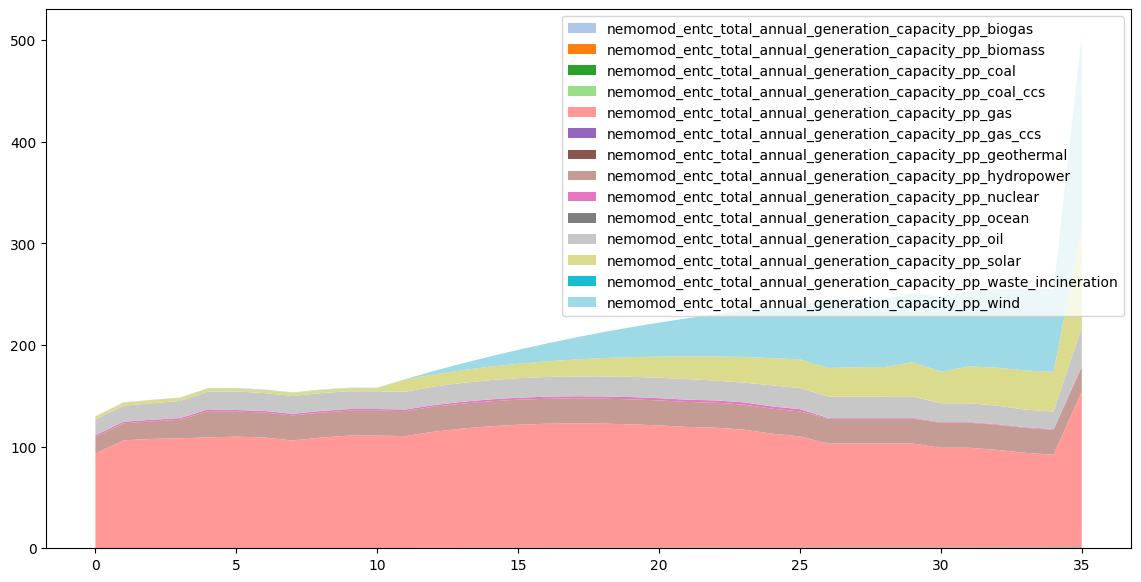

In [36]:
[x for x in df_out.columns if "entc" in x and "production" in x]
fields = [x for x in df_out.columns if ("nemomod_entc_annual_production_by_technology" in x) and ("_st_" not in x)]
fields = [x for x in df_out.columns if ("capacity" in x) and ("entc" in x) and ("_pp_" in x)]

df_plot = df_out[
    df_out[ssp.key_primary].isin([144144])
][fields]
importlib.reload(sup)

fields = list(df_plot.columns)
fig, ax = plt.subplots(figsize = (14, 7))
cmap = mpl.colormaps["tab20"]
colors = [cmap(x/len(fields)) for x in range(1, len(fields) + 1)]
#colors = ["orange", "dodgerblue", "forestgreen"]

sup.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),
    figtuple = (fig, ax),
)

ax.legend(loc = "upper right")
#ax.set_xlabel("Time Period")
#ax.set_ylabel("Biomass Carbon Emission, MT C02e")

#plt.savefig(
#    "/Users/usuario/git/ursa_sisepuede/images/sequestration_example.png",
#    bbox_inches = "tight",
#    dpi = 300,
#)


In [192]:
path_read = "/Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2024-12-02T22;49;38.625252/sisepuede_run_2024-12-02T22;49;38.625252_output_database"
path_read = pathlib.Path(path_read)
df_in = pd.read_csv(path_read.joinpath("MODEL_INPUT.CSV"))
df_out = pd.read_csv(path_read.joinpath("MODEL_OUTPUT.CSV"))



<Axes: >

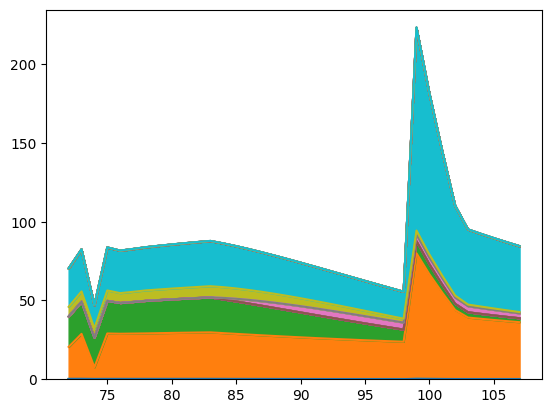

In [204]:
primary_id = 75075
df_in_cur = df_in[df_in["primary_id"].isin([primary_id])]
df_out_cur = df_out[df_out["primary_id"].isin([primary_id])]

fields = [
    x for x in df_out_cur if 
    ("emission_co2e" in x) 
    and ("entc" in x) 
    and ("generation" not in x)
    and ("subsector_total" not in x)
]

df_out_cur[fields].plot.area(legend = False)
#df_in_cur["nemomod_enfu_renewable_energy_minimum_production_target_fuel_electricity"]

In [207]:
for k in fields:
    print(k)


emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal
emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude
emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas
emission_co2e_ch4_entc_processing_and_refinement_fp_ammonia_production
emission_co2e_ch4_entc_processing_and_refinement_fp_hydrogen_electrolysis
emission_co2e_ch4_entc_processing_and_refinement_fp_hydrogen_gasification
emission_co2e_ch4_entc_processing_and_refinement_fp_hydrogen_reformation
emission_co2e_ch4_entc_processing_and_refinement_fp_hydrogen_reformation_ccs
emission_co2e_ch4_entc_processing_and_refinement_fp_natural_gas
emission_co2e_ch4_entc_processing_and_refinement_fp_petroleum_refinement
emission_co2e_co2_entc_fuel_mining_and_extraction_me_coal
emission_co2e_co2_entc_fuel_mining_and_extraction_me_crude
emission_co2e_co2_entc_fuel_mining_and_extraction_me_natural_gas
emission_co2e_co2_entc_processing_and_refinement_fp_ammonia_production
emission_co2e_co2_entc_processing_and_refinement_fp_hydroge

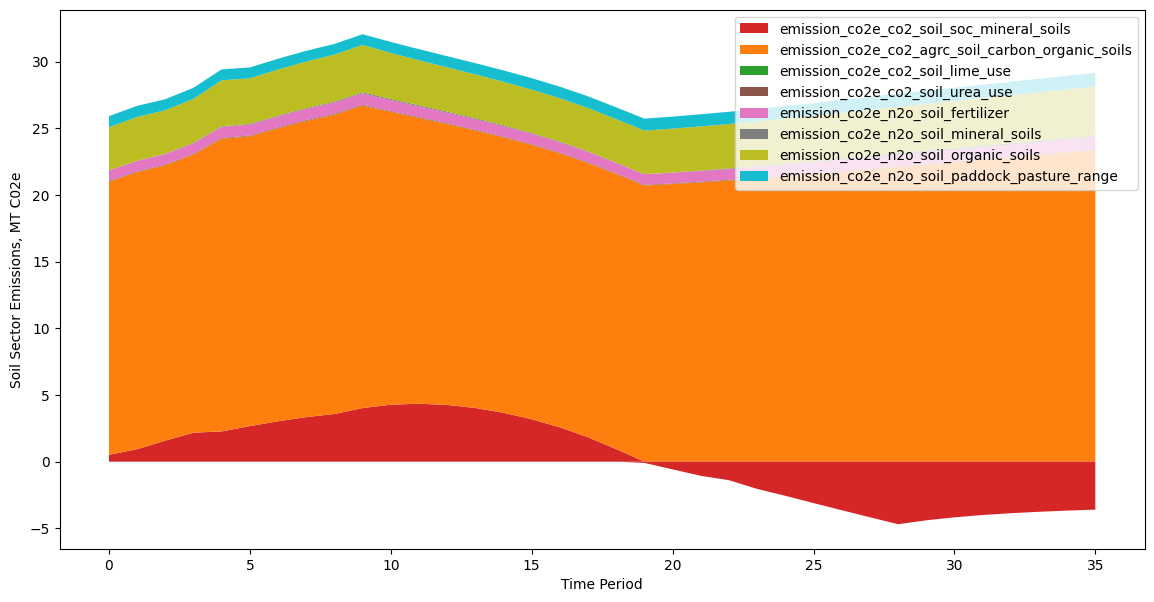

In [141]:
df_plot = df_out[
    df_out[ssp.key_primary].isin([77077])
][[x for x in df_out.columns if ("soil" in x) and ("emission_co2e" in x) and ("total" not in x)]]
importlib.reload(sup)

fields = list(df_plot.columns)
fig, ax = plt.subplots(figsize = (14, 7))

cmap = mpl.colormaps["tab10"]
colors = [cmap(x/len(fields)) for x in range(1, len(fields) + 1)]

sup.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),
    figtuple = (fig, ax),
)

ax.legend(loc = "upper right")
ax.set_xlabel("Time Period")
ax.set_ylabel("Soil Sector Emissions, MT C02e")

plt.savefig(
    "/Users/usuario/git/ursa_sisepuede/images/soil_carbon_example.png",
    bbox_inches = "tight",
    dpi = 300,
)


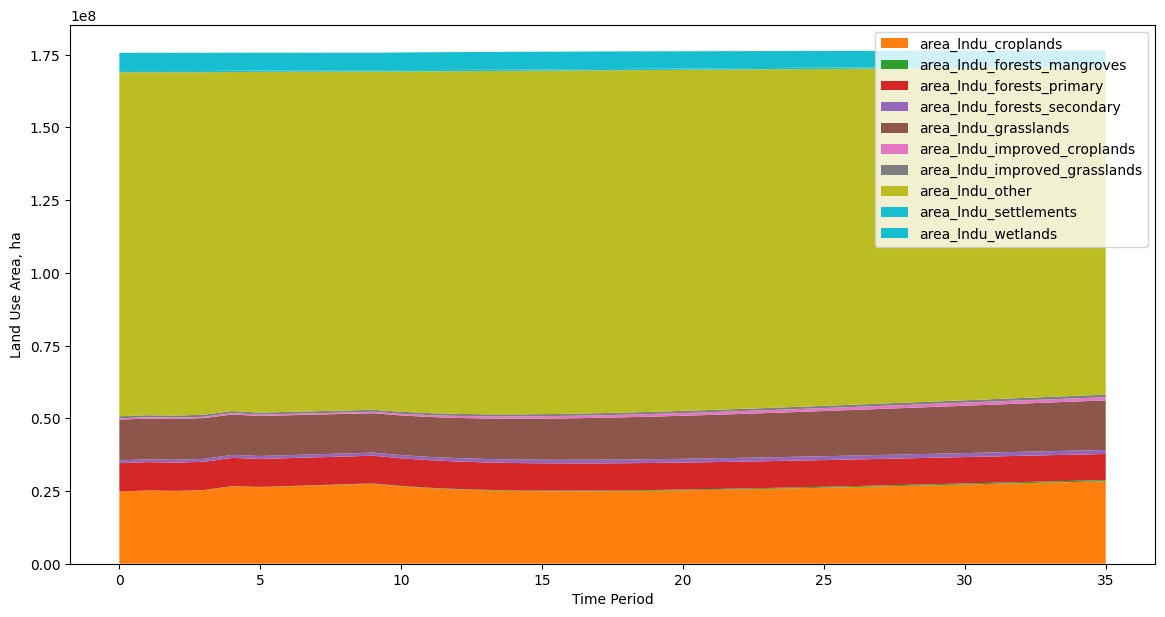

In [155]:
fields_area = [
    x for x in df_out.columns 
    if ("area_lndu" in x)
    and ("conversion" not in x)
]


df_plot = df_out[
    df_out[ssp.key_primary].isin([77077])
][fields_area]
importlib.reload(sup)

fields = list(df_plot.columns)
fig, ax = plt.subplots(figsize = (14, 7))

cmap = mpl.colormaps["tab10"]
colors = [cmap(x/len(fields)) for x in range(1, len(fields) + 1)]

sup.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),
    figtuple = (fig, ax),
)

ax.legend(loc = "upper right")
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Use Area, ha")

plt.savefig(
    "/Users/usuario/git/ursa_sisepuede/images/land_use_prevalence.png",
    bbox_inches = "tight",
    dpi = 300,
)


In [187]:
with open("/Users/usuario/Desktop/tmp.txt", "r") as fl:
    lines = fl.readlines()
#lines = [x.split(" = ")[0].strip() for x in lines]
#lines = [
#    f"{x} = p[{i + 1}]" for i, x in enumerate(lines)
#]
#lines = [x.split(" = ")[1].strip() for x in lines]

lines = [x.split(" = ")[0].strip() for x in lines]
lines = [f":{x}," for x in lines]

for k in lines:
    print(k)


:t=0,,
:POP,
:epsilon_f,
:epsilon_f_if,
:epsilon_f_ie,
:epsilon_f_c_fg,
:epsilon_f_c_fs,
:epsilon_f_cons,
:theta_g,
:theta_s,
:K_e,
:P_e,
:omega_f,
:omega_e,
:lambda_f,
:lambda_e,
:u_f_e,
:nu_f,
:d_f,
:d_e,
:r,
:of_b,
:chi,
:k_f,
:cum_y_nre,


In [173]:
with open("/Users/usuario/Desktop/tmp.txt", "r") as fl:
    lines = fl.readlines()

lines = [x.replace("\n", "").strip() for x in lines]
lines = [f"du[{i + 1}] = {x}" for i, x in enumerate(lines)]

for k in lines:
    print(k)


du[1] = 1
du[2] = p_5_POP_dot(t + 1)
du[3] = epsilon_f * epsilon_f_hat
du[4] = epsilon_f_if * epsilon_f_if_hat
du[5] = epsilon_f_ie * epsilon_f_ie_hat
du[6] = epsilon_f_c_fg * epsilon_f_c_fg_hat
du[7] = epsilon_f_c_fs * epsilon_f_c_fs_hat
du[8] = epsilon_f_cons * epsilon_f_cons_hat
du[9] = theta_g * theta_g_hat
du[10] = theta_s * theta_s_hat
du[11] = K_e * (k_hat_e - k_hat_f) # K_e
du[12] = P_e * (p_hat_e - p_hat_f)
du[13] = omega_f * (omega_0  + omega_1*lambda - omega_3*p_hat_f - alpha_0 - alpha_1*lambda)
du[14] = omega_e * (omega_0  + omega_1*lambda - omega_3*p_hat_f + (p_hat_f-p_hat_e) - alpha_0 - alpha_1*lambda )
du[15] = lambda_f * ( k_hat_f + u_f_switch/u_f - alpha_0 - alpha_1*lambda - p_5_POP_hat(t + 1) )
du[16] = lambda_e * ( k_hat_e - alpha_0 - alpha_1*lambda - p_5_POP_hat(t+1) )
du[17] = u_f_switch
du[18] = u_f/gamma_f - ( K_e*(k_hat_e+delta_e) + k_hat_f + delta_f + kappa_hf + kappa_cf ) - (k_hat_f+delta_n)*nu_f
du[19] = k_hat_f - pi_f + div*pi_fe - d_f*(p_hat_f + k_hat_f)
du

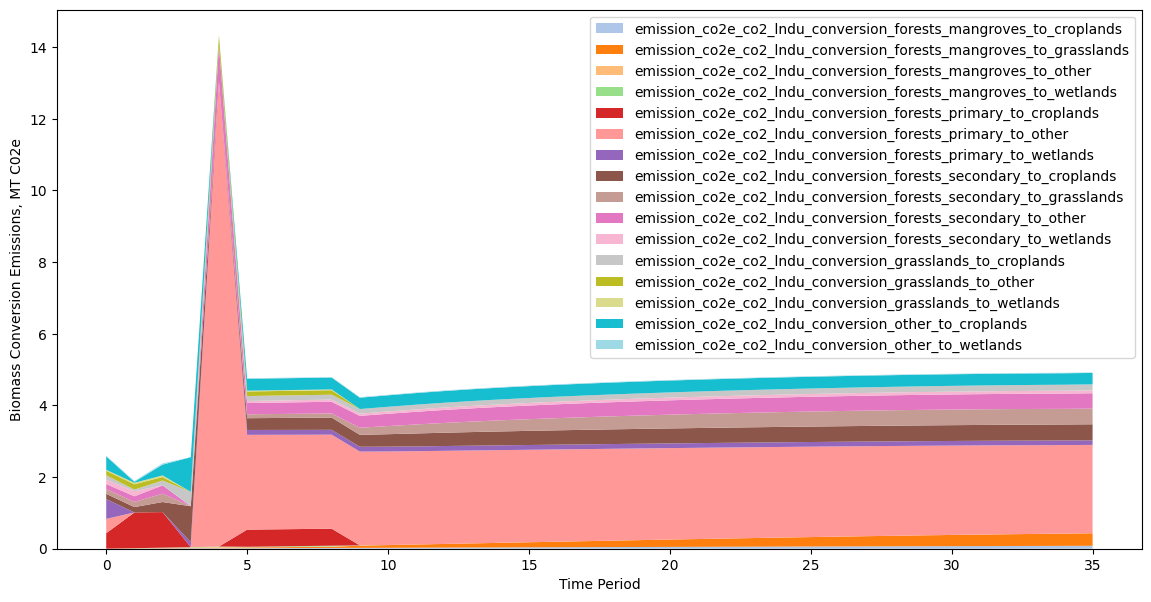

In [152]:
fields_conv = [
    x for x in df_out.columns 
    if ("emission_co2e_co2_lndu_conversion_" in x) and ("_to_" in x)
    and np.abs(df_out[x]).max() > 0
]


df_plot = df_out[
    df_out[ssp.key_primary].isin([77077])
][fields_conv]
importlib.reload(sup)

fields = list(df_plot.columns)
fig, ax = plt.subplots(figsize = (14, 7))

cmap = mpl.colormaps["tab20"]
colors = [cmap(x/len(fields)) for x in range(1, len(fields) + 1)]

sup.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),
    figtuple = (fig, ax),
)

ax.legend(loc = "upper right")
ax.set_xlabel("Time Period")
ax.set_ylabel("Biomass Conversion Emissions, MT C02e")

plt.savefig(
    "/Users/usuario/git/ursa_sisepuede/images/conversion_example.png",
    bbox_inches = "tight",
    dpi = 300,
)


In [25]:
df_out[
    df_out[ssp.key_time_period].isin([35])
][[ssp.key_primary] + ["qty_trww_n_removed_tonne"]]#[x for x in df_out.columns if ("bod" in x)]]

,primary_id,qty_trww_n_removed_tonne
35,0,360221.006467
71,74074,488466.472100
107,75075,488334.694457
143,76076,717591.527155


In [27]:
df_tmp = pd.read_csv("/Users/usuario/git/sisepuede/sisepuede/out/sisepuede_summary_results_run_sisepuede_run_2024-11-25T11;15;14.469816/sisepuede_results_sisepuede_run_2024-11-25T11;15;14.469816_WIDE_INPUTS_OUTPUTS.csv")
df_tmp[
    df_tmp[ssp.key_time_period].isin([35])
][[ssp.key_primary] +["qty_trww_n_removed_tonne"]]#[x for x in df_tmp.columns if ("bod" in x)]]



,primary_id,qty_trww_n_removed_tonne
35,0,266926.092697
71,69069,138999.281281
107,70070,284652.808100
143,71071,484961.340467


In [338]:
df_check = df_in[df_in[ssp.key_primary].isin([75075])]
df_check_out = df_out[df_out[ssp.key_primary].isin([75075])]
df_check2 = df_in[df_in[ssp.key_primary].isin([76076])]

cols = []
for x in df_check.columns:
    v0 = df_check[x].to_numpy()
    v1 = df_check2[x].to_numpy()

    #if any([np.isnan(k) for k in v1 if sf.isnumber(k)]):
    #    print(x)

    if not sf.isnumber(v0[0]):
        continue
        
    err = (v1 - v0)
    if err.max() > 0.001:
        cols.append(x)




df_check = df_out[df_out[ssp.key_primary].isin([75075])]
for x in df_check.columns:
    v0 = df_check[x].to_numpy()

    if any([np.isnan(k) for k in v0 if sf.isnumber(k, skip_nan = False)]):
        print(x)


In [382]:
df_check = df_in[df_in[ssp.key_primary].isin([75075])]
df_check_out = df_out[df_out[ssp.key_primary].isin([75075])]
df_tmp = pd.merge(df_check, df_check_out)



mod = ssp.models.model_enerprod
dict_ref_tables = mod.dict_nemomod_reference_tables
dict_to_sql = mod.generate_input_tables_for_sql(
    df_tmp,
    dict_ref_tables.get(mod.model_attributes.table_nemomod_availability_factor),
    dict_ref_tables.get(mod.model_attributes.table_nemomod_specified_demand_profile),
)

import sqlalchemy
import sisepuede.utilities._sql as sqlutil


os.remove(ssp.file_struct.fp_sqlite_tmp_nemomod_intermediate)
mod.julia_main.NemoMod.createnemodb(ssp.file_struct.fp_sqlite_tmp_nemomod_intermediate)
engine = sqlalchemy.create_engine(f"sqlite:///{ssp.file_struct.fp_sqlite_tmp_nemomod_intermediate}")
sqlutil._write_dataframes_to_db(
    dict_to_sql,
    engine
)

2024-02-Dec 22:41:02.312 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-02-Dec 22:41:02.331 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.


In [387]:
tabs = mod.retrieve_output_tables_from_sql(
    engine, 
    df_tmp, 
    #tuple_enfu_production_and_demands = tuple_enfu_production_and_demands,
)

TypeError: 'NoneType' object is not subscriptable

In [384]:
engine

Engine(sqlite:////Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite)

In [354]:
x = "emission_co2e_ch4_entc_processing_and_refinement_fp_ammonia_production"
v0 = df_check[x].to_numpy()
[np.isnan(k) for k in v0 if sf.isnumber(k, skip_nan = False)]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [351]:
df1 = df_out[
    df_out[ssp.key_time_period].isin([35])
][[ssp.key_primary] + [x for x in df_out.columns if ("production" in x) & ("entc" in x)]]
df1


,primary_id,emission_co2e_ch4_entc_processing_and_refinement_fp_ammonia_production,emission_co2e_co2_entc_processing_and_refinement_fp_ammonia_production,emission_co2e_n2o_entc_processing_and_refinement_fp_ammonia_production,nemomod_entc_annual_production_by_technology_pp_biogas,nemomod_entc_annual_production_by_technology_pp_biomass,nemomod_entc_annual_production_by_technology_pp_coal,nemomod_entc_annual_production_by_technology_pp_coal_ccs,nemomod_entc_annual_production_by_technology_pp_gas,nemomod_entc_annual_production_by_technology_pp_gas_ccs,...,nemomod_entc_annual_production_by_technology_pp_oil,nemomod_entc_annual_production_by_technology_pp_solar,nemomod_entc_annual_production_by_technology_pp_waste_incineration,nemomod_entc_annual_production_by_technology_pp_wind,nemomod_entc_annual_production_by_technology_st_batteries,nemomod_entc_annual_production_by_technology_st_compressed_air,nemomod_entc_annual_production_by_technology_st_flywheels,nemomod_entc_annual_production_by_technology_st_pumped_hydro,nemomod_entc_discounted_capital_investment_fp_ammonia_production,nemomod_entc_discounted_operating_costs_fp_ammonia_production
35,0,0.0,0.0,0.0,0.945794,0.0,3.918181,0.0,1625.124875,0.0,...,274.349832,67.933187,0.110888,4.474772,-3.495583e-12,0.0,0.0,0.0,0.0,0.0
71,74074,0.0,0.0,0.0,0.858629,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,104.254479,0.098986,1200.424143,0.000000e+00,0.0,0.0,0.0,0.0,0.0
107,75075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,76076,0.0,0.0,0.0,18.628396,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,225.462522,0.009563,1812.503183,-1.218073e-13,0.0,0.0,0.0,0.0,0.0


In [144]:
"""df_in = strategies.get_strategy(6005)
df_out = ssp.models.project(
    df_in(),
    include_electricity_in_energy = False
);


[x for x in dir(ssp.models.model_enercons) if x.startswith("modvar_trns")]
matt.extract_model_variable(
    df_out,
    ssp.models.model_enercons.modvar_trns_vehicle_distance_traveled
).tail()
""";

In [286]:
df_cur = strategies.get_strategy(0)
df_cur = df_cur()
df_cur = df_out[df_out["primary_id"].isin([0])]

df_cur[[x for x in df_cur.columns if "import" in x and "lvst" in x]].tail()

,importssadj_lvst_buffalo,importssadj_lvst_cattle_dairy,importssadj_lvst_cattle_nondairy,importssadj_lvst_chickens,importssadj_lvst_goats,importssadj_lvst_horses,importssadj_lvst_mules,importssadj_lvst_pigs,importssadj_lvst_sheep,qty_lvst_changes_in_net_imports_lost_buffalo,qty_lvst_changes_in_net_imports_lost_cattle_dairy,qty_lvst_changes_in_net_imports_lost_cattle_nondairy,qty_lvst_changes_in_net_imports_lost_chickens,qty_lvst_changes_in_net_imports_lost_goats,qty_lvst_changes_in_net_imports_lost_horses,qty_lvst_changes_in_net_imports_lost_mules,qty_lvst_changes_in_net_imports_lost_pigs,qty_lvst_changes_in_net_imports_lost_sheep
31,37761.688192,794297.276750,1.491229e+06,340179.220497,4.895868e+06,48027.756842,86295.958709,0.0,1.698552e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,38762.762263,834668.711980,1.552293e+06,345307.197386,5.122261e+06,50029.485665,89100.345774,0.0,1.765252e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,39722.885067,873482.182753,1.611673e+06,350403.831269,5.343302e+06,51984.698360,91837.453167,0.0,1.830367e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,40642.580355,910719.506929,1.669324e+06,355463.637122,5.558812e+06,53890.858062,94505.018314,0.0,1.893843e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,41510.443746,945926.161167,1.724750e+06,360462.585305,5.767134e+06,55732.459394,97082.527132,0.0,1.955187e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_in = strategies.get_strategy(0)
df_out = ssp.models.project(
    df_in(),
    include_electricity_in_energy = False
);
matt.extract_model_variable(
    df_out,
    ssp.models.model_enercons.modvar_trns_vehicle_distance_traveled
).tail()

<Axes: >

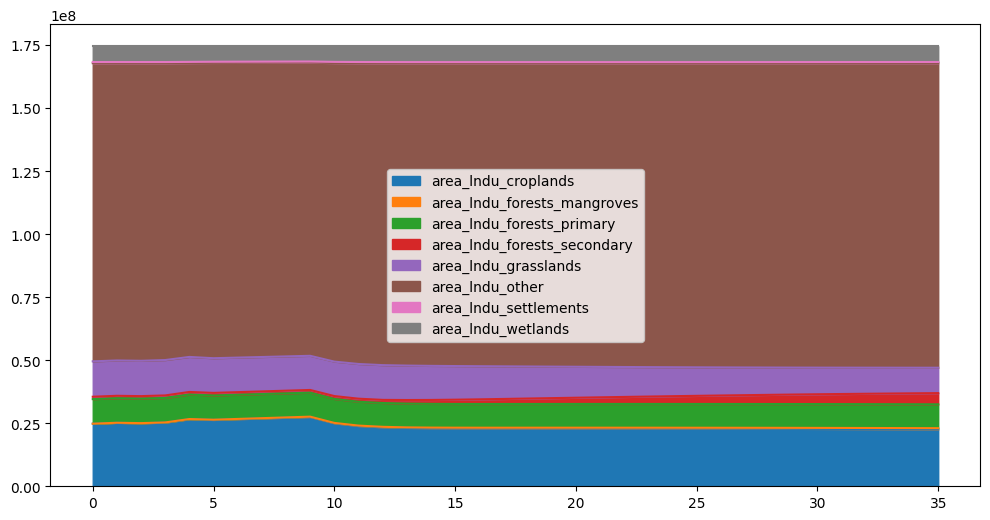

In [228]:
df_in = strategies.get_strategy(6005)
df_in = df_in().copy()

df_out_af = ssp.models.model_afolu.project(df_in)

vec = np.array([0 for x in range(10)] + [0.5 for x in range(26)])
df_in["lndu_reallocation_factor"] = vec#df_in["lndu_reallocation_factor"].to_numpy() * 2
df_out_af = ssp.models.model_afolu.project(df_in)

fig, ax = plt.subplots(figsize = (12, 6))
(
    matt.extract_model_variable(
        df_out_af,
        "Land Use Area"
    )
    .plot
    .area(ax = ax, )
)

In [350]:
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: [0, 6003, 6004, 6005],
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2024-11-14 13:20:26,113 - INFO - 
***	STARTING REGION iran	***

2024-11-14 13:20:26,113 - INFO - 
***	STARTING REGION iran	***

2024-11-14 13:20:26,113 - INFO - 
***	STARTING REGION iran	***

2024-11-14 13:20:26,113 - INFO - 
***	STARTING REGION iran	***

2024-11-14 13:20:26,113 - INFO - 
***	STARTING REGION iran	***

2024-11-14 13:20:27,700 - INFO - Trying run primary_id = 0 in region iran
2024-11-14 13:20:27,700 - INFO - Trying run primary_id = 0 in region iran
2024-11-14 13:20:27,700 - INFO - Trying run primary_id = 0 in region iran
2024-11-14 13:20:27,700 - INFO - Trying run primary_id = 0 in region iran
2024-11-14 13:20:27,700 - INFO - Trying run primary_id = 0 in region iran
2024-11-14 13:20:27,701 - INFO - Running AFOLU model
2024-11-14 13:20:27,701 - INFO - Running AFOLU model
2024-11-14 13:20:27,701 - INFO - Running AFOLU model
2024-11-14 13:20:27,701 - INFO - Running AFOLU model
2024-11-14 13:20:27,701 - INFO - Running AFOLU model
2024-11-14 13:20:27,787 - INFO - AFOLU model 

2024-14-Nov 13:20:27.943 Opened SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-14-Nov 13:20:27.953 Added NEMO structure to SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-14-Nov 13:20:28.478 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-14 13:21:31,213 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:21:31,213 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:21:31,213 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:21:31,213 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:21:31,213 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:21:31,227 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:21:31,227 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:21:31,227 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:21:31,227 - INFO - EnergyProduction model run successfully completed
20

2024-14-Nov 13:21:31.111 Finished modeling scenario.


2024-11-14 13:21:31,378 - INFO - AFOLU model run successfully completed
2024-11-14 13:21:31,378 - INFO - AFOLU model run successfully completed
2024-11-14 13:21:31,378 - INFO - AFOLU model run successfully completed
2024-11-14 13:21:31,378 - INFO - AFOLU model run successfully completed
2024-11-14 13:21:31,378 - INFO - AFOLU model run successfully completed
2024-11-14 13:21:31,379 - INFO - Running CircularEconomy model
2024-11-14 13:21:31,379 - INFO - Running CircularEconomy model
2024-11-14 13:21:31,379 - INFO - Running CircularEconomy model
2024-11-14 13:21:31,379 - INFO - Running CircularEconomy model
2024-11-14 13:21:31,379 - INFO - Running CircularEconomy model
2024-11-14 13:21:31,408 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:21:31,408 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:21:31,408 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:21:31,408 - INFO - CircularEconomy model run successfully complet

2024-14-Nov 13:21:32.139 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-14 13:22:11,982 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:22:11,982 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:22:11,982 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:22:11,982 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:22:11,982 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:22:11,992 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:22:11,992 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:22:11,992 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:22:11,992 - INFO - EnergyProduction model run successfully completed
20

2024-14-Nov 13:22:11.891 Finished modeling scenario.


2024-11-14 13:22:12,159 - INFO - AFOLU model run successfully completed
2024-11-14 13:22:12,159 - INFO - AFOLU model run successfully completed
2024-11-14 13:22:12,159 - INFO - AFOLU model run successfully completed
2024-11-14 13:22:12,159 - INFO - AFOLU model run successfully completed
2024-11-14 13:22:12,159 - INFO - AFOLU model run successfully completed
2024-11-14 13:22:12,160 - INFO - Running CircularEconomy model
2024-11-14 13:22:12,160 - INFO - Running CircularEconomy model
2024-11-14 13:22:12,160 - INFO - Running CircularEconomy model
2024-11-14 13:22:12,160 - INFO - Running CircularEconomy model
2024-11-14 13:22:12,160 - INFO - Running CircularEconomy model
2024-11-14 13:22:12,186 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:22:12,186 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:22:12,186 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:22:12,186 - INFO - CircularEconomy model run successfully complet

2024-14-Nov 13:22:13.555 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-14 13:23:04,313 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:23:04,313 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:23:04,313 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:23:04,313 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:23:04,313 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:23:04,321 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:23:04,321 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:23:04,321 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:23:04,321 - INFO - EnergyProduction model run successfully completed
20

2024-14-Nov 13:23:04.237 Finished modeling scenario.


2024-11-14 13:23:04,451 - INFO - AFOLU model run successfully completed
2024-11-14 13:23:04,451 - INFO - AFOLU model run successfully completed
2024-11-14 13:23:04,451 - INFO - AFOLU model run successfully completed
2024-11-14 13:23:04,451 - INFO - AFOLU model run successfully completed
2024-11-14 13:23:04,451 - INFO - AFOLU model run successfully completed
2024-11-14 13:23:04,451 - INFO - Running CircularEconomy model
2024-11-14 13:23:04,451 - INFO - Running CircularEconomy model
2024-11-14 13:23:04,451 - INFO - Running CircularEconomy model
2024-11-14 13:23:04,451 - INFO - Running CircularEconomy model
2024-11-14 13:23:04,451 - INFO - Running CircularEconomy model
2024-11-14 13:23:04,476 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:23:04,476 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:23:04,476 - INFO - CircularEconomy model run successfully completed
2024-11-14 13:23:04,476 - INFO - CircularEconomy model run successfully complet

2024-14-Nov 13:23:05.158 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-14 13:24:08,094 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:24:08,094 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:24:08,094 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:24:08,094 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:24:08,094 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-14 13:24:08,103 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:24:08,103 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:24:08,103 - INFO - EnergyProduction model run successfully completed
2024-11-14 13:24:08,103 - INFO - EnergyProduction model run successfully completed
20

2024-14-Nov 13:24:08.014 Finished modeling scenario.


2024-11-14 13:24:08,235 - INFO - Table MODEL_OUTPUT successfully written to /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-14T13;20;07.668137/sisepuede_run_2024-11-14T13;20;07.668137_output_database/MODEL_OUTPUT.csv.
2024-11-14 13:24:08,235 - INFO - Table MODEL_OUTPUT successfully written to /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-14T13;20;07.668137/sisepuede_run_2024-11-14T13;20;07.668137_output_database/MODEL_OUTPUT.csv.
2024-11-14 13:24:08,235 - INFO - Table MODEL_OUTPUT successfully written to /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-14T13;20;07.668137/sisepuede_run_2024-11-14T13;20;07.668137_output_database/MODEL_OUTPUT.csv.
2024-11-14 13:24:08,235 - INFO - Table MODEL_OUTPUT successfully written to /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepued

{'iran': [0, 69069, 70070, 71071]}

In [173]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [352]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [61]:
(
    df_out
    .to_csv(
        dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
        index = None,
        encoding = "UTF-8",
    )
)

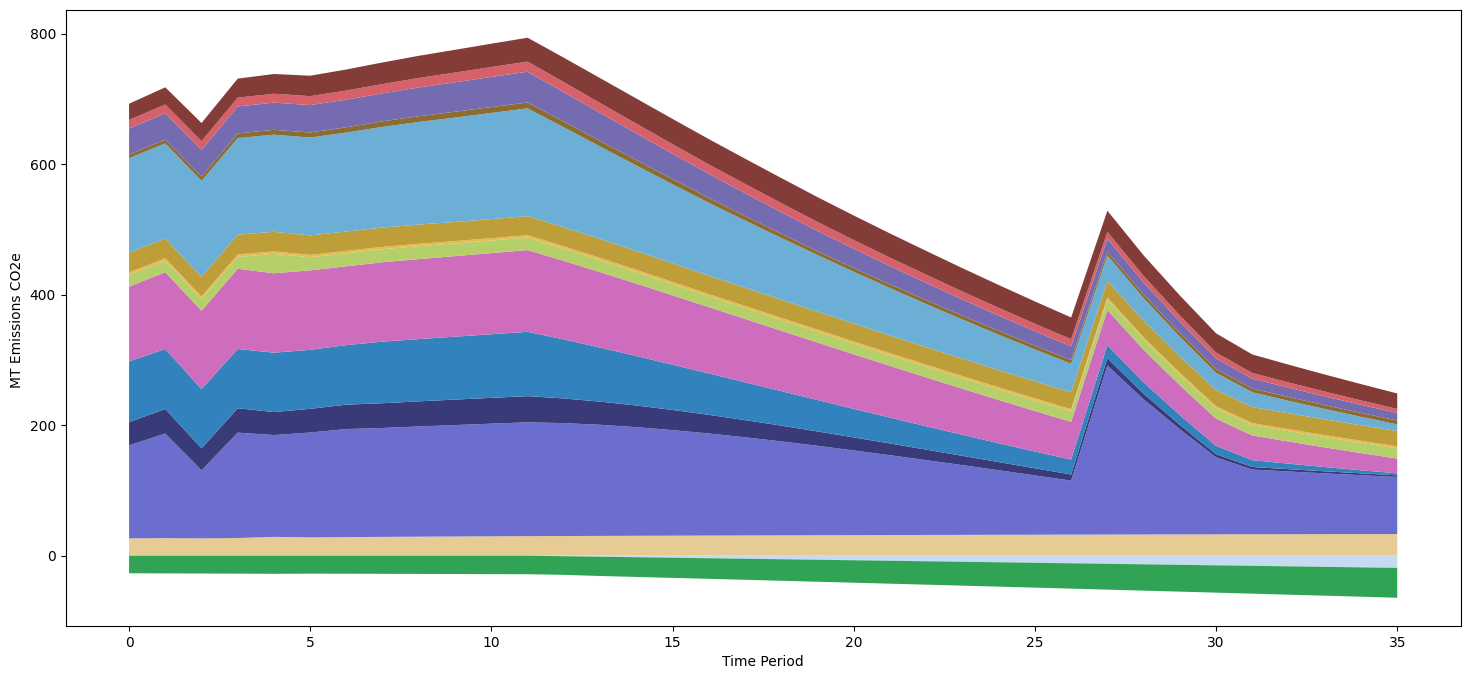

In [354]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([70070])
]

df_in_plot = df_in[
    df_in[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)



In [220]:
fields_emission = ssp.model_attributes.get_all_subsector_emission_total_fields()
#fields_emssion = [x for x in df_out.columns if ("emission" in x) and ("entc" in x) and ("me" in x) and ("_co2_" in x)]


df_plot1 = df_out[
    df_out[ssp.key_primary].isin([70070])
]
df_plot2 = df_out[
    df_out[ssp.key_primary].isin([71071])
]


df_plot1[fields_emission].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_waso,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_scoe,emission_co2e_subsector_total_trns,emission_co2e_subsector_total_ippu
103,21.942749,-62.634620,18.438479,1.710645,13.392692,6.059590,28.433161,8.521264,-15.544748,94.179755,3.880019,9.687851,22.555176,15.266530,37.825633
104,21.703266,-64.481763,18.461609,1.605094,12.543353,5.857032,27.320127,7.963442,-16.321986,91.511491,3.477416,7.709620,19.102446,14.286277,33.950782
105,21.478304,-66.260600,18.484131,1.505036,11.739729,5.669738,26.166232,7.373934,-17.099223,88.980183,3.110690,5.856133,15.886736,13.350461,30.126817
106,21.264667,-67.985992,18.496089,1.409296,10.972443,5.529901,24.970492,6.751790,-17.876461,86.577407,2.777385,4.119035,12.900425,12.457090,26.354530
107,21.057956,-69.641082,18.503507,1.313922,10.210772,5.427103,23.731171,6.095561,-18.653698,84.294008,2.475140,2.490576,10.135902,11.603317,22.655620


In [219]:
df_plot2[fields_emission].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_waso,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_scoe,emission_co2e_subsector_total_trns,emission_co2e_subsector_total_ippu
139,22.734423,-62.277353,17.083467,1.204870,8.942382,6.807702,24.514498,7.700606,-25.907914,82.521881,2.079126,6.780322,12.227396,10.625466,39.919147
140,22.535815,-64.108585,17.093585,1.084165,8.093000,6.768030,23.276018,7.043159,-27.203310,79.871349,1.757743,5.007025,8.956377,9.676687,36.293195
141,22.348289,-65.872987,17.103662,0.970436,7.301284,6.739065,22.016095,6.346289,-28.498705,77.384414,1.473591,3.359268,5.947408,8.784150,32.715122
142,22.168996,-67.585275,17.103687,0.862874,6.559847,6.744798,20.732648,5.608681,-29.794101,75.051896,1.223002,1.827351,3.190597,7.945195,29.185533
143,21.993735,-69.228562,17.099542,0.759202,5.849872,6.768042,19.422353,4.828597,-31.089497,72.865824,1.002502,0.402648,0.676893,7.156788,25.705167


In [ ]:
#
# imports < demand - exports (not going to allow importing to export)
#

In [112]:
#[x for x in dir(ssp.model_attributes) if "emission" in x and "get" in x]

In [172]:
if True:
    fields = [
        x for x in df_inputs.columns
        if True
            & ("entc" in x)
            & ("_oil" in x)
    ]

if True:
    fields = [
        x for x in df_inputs.columns
        if True
            & ("frac_inen" in x)
            & ("_oil" in x)
    ]

df_inputs[fields].iloc[0]



frac_inen_energy_agriculture_and_livestock_oil      0.499920
frac_inen_energy_cement_oil                         0.005647
frac_inen_energy_chemicals_oil                      0.000001
frac_inen_energy_electronics_oil                    0.000000
frac_inen_energy_glass_oil                          0.005647
frac_inen_energy_lime_and_carbonite_oil             0.000000
frac_inen_energy_metals_oil                         0.001990
frac_inen_energy_mining_oil                         0.000000
frac_inen_energy_other_product_manufacturing_oil    0.000000
frac_inen_energy_paper_oil                          0.006181
frac_inen_energy_plastic_oil                        0.001458
frac_inen_energy_recycled_glass_oil                 0.001210
frac_inen_energy_recycled_metals_oil                0.000000
frac_inen_energy_recycled_paper_oil                 0.000000
frac_inen_energy_recycled_plastic_oil               0.575147
frac_inen_energy_recycled_rubber_and_leather_oil    0.000731
frac_inen_energy_recycle

In [178]:
modvar_init = matt.get_variable("Initial Energy Consumption in Agriculture and Livestock")
matt.extract_model_variable(
    df_inputs,
    modvar_init
).head()


,consumpinit_inen_energy_total_pj_agriculture_and_livestock
0,152.873605
1,154.778478
2,156.749433
3,158.749489
4,160.729482


In [180]:
modvar_inen_cons = matt.get_variable("Energy Consumption from Industrial Energy")
matt.extract_model_variable(
    df_plot,
    modvar_inen_cons
).iloc[9]



energy_consumption_inen_agriculture_and_livestock      175.940892
energy_consumption_inen_cement                          55.985809
energy_consumption_inen_chemicals                       77.700940
energy_consumption_inen_electronics                     14.268034
energy_consumption_inen_glass                          128.680557
energy_consumption_inen_lime_and_carbonite               0.000000
energy_consumption_inen_metals                         510.276163
energy_consumption_inen_mining                         198.270328
energy_consumption_inen_other_product_manufacturing    491.232500
energy_consumption_inen_paper                           18.201039
energy_consumption_inen_plastic                          7.194450
energy_consumption_inen_recycled_glass                   0.000000
energy_consumption_inen_recycled_metals                  0.000000
energy_consumption_inen_recycled_paper                   0.000000
energy_consumption_inen_recycled_plastic                 0.000000
energy_con

In [158]:
#df_in_plot[[x for x in df_in_plot.columns if ("enfu" in x) and ("export" in x)]]
fields = [x for x in df_plot.columns if ("enfu" in x) and ("fuel_oil" in x)]
df_plot[fields].iloc[25:28]


,energy_demand_enfu_subsector_total_pj_ccsq_fuel_oil,energy_demand_enfu_subsector_total_pj_entc_fuel_oil,energy_demand_enfu_subsector_total_pj_inen_fuel_oil,energy_demand_enfu_subsector_total_pj_scoe_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_total_fuel_oil,exportsadj_enfu_fuel_oil,imports_enfu_fuel_oil_pj,prod_enfu_fuel_oil_pj,totalvalue_enfu_fuel_consumed_entc_fuel_oil,totalvalue_enfu_fuel_consumed_inen_fuel_oil
97,0.0,191.490105,54.066631,0.0,0.0,245.556736,77.608411,283.291906,39.873241,2.519607,0.711403
98,0.0,157.282715,49.073550,0.0,0.0,206.356265,77.585733,245.404385,38.537613,2.069509,0.645705
99,0.0,170.199662,44.357835,0.0,0.0,214.557497,77.564314,0.483531,291.638280,2.239469,0.583656


In [187]:
df_iter = df_plot.drop(columns = ["primary_id", "region", "time_period"])
for x in df_iter.columns:

    err = np.abs(1 - df_iter[x].iloc[26]/df_iter[x].iloc[25])
    if err > 0.8:
        print(x)



demand_agrc_bevs_and_spices_tonne
demand_agrc_fibers_tonne
demand_agrc_fruits_tonne
demand_agrc_nuts_tonne
demand_agrc_other_annual_tonne
demand_agrc_other_woody_perennial_tonne
demand_agrc_sugar_cane_tonne
emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude
emission_co2e_ch4_entc_generation_for_entc
emission_co2e_ch4_entc_processing_and_refinement_fp_petroleum_refinement
emission_co2e_ch4_fgtv_fuel_oil
emission_co2e_ch4_trww_treated_septic_treatment
emission_co2e_co2_entc_fuel_mining_and_extraction_me_crude
emission_co2e_co2_entc_generation_for_entc
emission_co2e_co2_entc_processing_and_refinement_fp_petroleum_refinement
emission_co2e_co2_fgtv_fuel_oil
emission_co2e_n2o_entc_fuel_mining_and_extraction_me_crude
emission_co2e_n2o_entc_generation_for_entc
emission_co2e_n2o_entc_processing_and_refinement_fp_petroleum_refinement
emission_co2e_n2o_fgtv_fuel_oil
emission_co2e_subsector_total_entc
emission_nongas_fgtv_kt_nmvoc_fuel_oil
energy_demand_enfu_subsector_total_pj_entc_fuel_cr

In [203]:
df_in_plot["frac_enfu_fuel_demand_imported_pj_fuel_gasoline"]

108    0.031667
109    0.047786
110    0.031667
111    0.031667
112    0.031667
113    0.031667
114    0.031667
115    0.031667
116    0.031667
117    0.031667
118    0.031667
119    0.031667
120    0.031667
121    0.031667
122    0.031667
123    0.031667
124    0.031667
125    0.031667
126    0.031667
127    0.031667
128    0.031667
129    0.031667
130    0.031667
131    0.031667
132    0.031667
133    0.031667
134    0.031667
135    0.031667
136    0.031667
137    0.031667
138    0.031667
139    0.031667
140    0.031667
141    0.031667
142    0.031667
143    0.031667
Name: frac_enfu_fuel_demand_imported_pj_fuel_gasoline, dtype: float64

<Axes: >

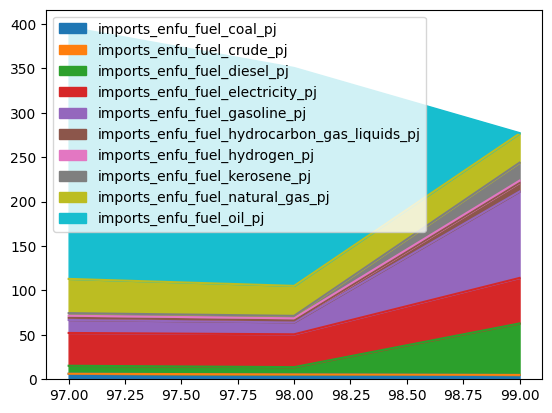

In [147]:
df_plot[[x for x in df_plot.columns if x.startswith("imports_enfu_") and ("ammonia" not in x)]].iloc[25:28].plot.area()

In [235]:
mp = ssp.models.model_enerprod
mp.get_enfu_cats_with_high_dummy_tech_costs(imports_only = True, )
dict_tech_info = mp.get_tech_info_dict()
dict_fuels_to_dummy_techs = dict_tech_info.get("dict_fuels_to_dummy_techs")



In [34]:
import sqlalchemy
import sisepuede.utilities._sql as squ

fp = ssp.file_struct.fp_sqlite_tmp_nemomod_intermediate
engine = sqlalchemy.create_engine(f"sqlite:///{fp}")
squ.get_table_names(engine)

['AccumulatedAnnualDemand',
 'AnnualEmissionLimit',
 'AnnualExogenousEmission',
 'AvailabilityFactor',
 'CapacityOfOneTechnologyUnit',
 'CapacityToActivityUnit',
 'CapitalCost',
 'CapitalCostStorage',
 'DefaultParams',
 'DepreciationMethod',
 'DiscountRate',
 'EMISSION',
 'EmissionActivityRatio',
 'EmissionsPenalty',
 'FUEL',
 'FixedCost',
 'InputActivityRatio',
 'InterestRateStorage',
 'InterestRateTechnology',
 'LTsGroup',
 'MODE_OF_OPERATION',
 'MinShareProduction',
 'MinStorageCharge',
 'MinimumUtilization',
 'ModelPeriodEmissionLimit',
 'ModelPeriodExogenousEmission',
 'NODE',
 'NodalDistributionDemand',
 'NodalDistributionStorageCapacity',
 'NodalDistributionTechnologyCapacity',
 'OperationalLife',
 'OperationalLifeStorage',
 'OutputActivityRatio',
 'REGION',
 'REGIONGROUP',
 'REMinProductionTarget',
 'REMinProductionTargetRG',
 'RETagTechnology',
 'RRGroup',
 'RampRate',
 'RampingReset',
 'ReserveMargin',
 'ReserveMarginTagFuel',
 'ReserveMarginTagTechnology',
 'ResidualCapacity

In [338]:
?sm.SISEPUEDEModels

Init signature:
sm.SISEPUEDEModels(
    model_attributes: sisepuede.core.model_attributes.ModelAttributes,
    allow_electricity_run: bool = True,
    fp_julia: Optional[str] = None,
    fp_nemomod_reference_files: Optional[str] = None,
    fp_nemomod_temp_sqlite_db: Optional[str] = None,
    initialize_julia: bool = True,
    logger: Optional[logging.Logger] = None,
)
Docstring:     
Instantiate models for SISEPUEDE.

Initialization Arguments
------------------------
- model_attributes: ModelAttributes object used to manage variables and
        coordination

Optional Arguments
------------------
- allow_electricity_run: allow the electricity model to run (high-runtime
        model)
        * Generally should be left to True
- fp_nemomod_reference_files: directory housing reference files called by
        NemoMod when running electricity model
        * REQUIRED TO RUN ELECTRICITY MODEL
- fp_nemomod_temp_sqlite_db: optional file path to use for SQLite database
        used in Julia N

In [181]:
#strat6005 = strategies.get_strategy(6005)
#df_run = strat6005()

df_inputs2 = df_inputs.copy() 

# modify this downward
fld = "consumpinit_inen_energy_total_pj_agriculture_and_livestock"
df_inputs2[fld] = df_inputs2[fld].to_numpy()/3

transformers2 = trf.transformers.Transformers(
    {},
    df_input = df_inputs2,
)

transformations2 = trf.Transformations(
    dir_transformations,
    transformers = transformers2,
)

#  build the strategies -- will export to path
t0 = time.time()
strategies2 = trf.Strategies(
    transformations2,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")


df_run = strategies2.get_strategy(6005)
df_run = df_run()


# run model
df_out2 = ssp.models.project(df_run, include_electricity_in_energy = False)


Strategies defined at /Users/usuario/git/sisepuede_region_nbs/iran/transformations initialized in 2.51 seconds


In [193]:
modvar_dem = matt.get_variable("Energy Demand by Fuel in Energy Technology")#Total Energy Demand by Fuel")
matt.extract_model_variable(
    df_out,
    modvar_dem,
)

unit = matt.get_unit("energy")
367669*unit.convert("gwh", "pj")

1323.6084

In [70]:
from typing import *

In [71]:
import sisepuede.manager.sisepuede_models as sm

models = sm.SISEPUEDEModels(
    ssp.model_attributes,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)

In [73]:
?ssp.models.project

Signature:
ssp.models.project(
    df_input_data: pandas.core.frame.DataFrame,
    check_results: bool = True,
    fields_check: Union[List[str], str, NoneType] = 'emissions_output_subsector_aggregate',
    include_electricity_in_energy: bool = True,
    models_run: Optional[List[str]] = None,
    regions: Union[List[str], str, NoneType] = None,
    run_integrated: bool = True,
    time_periods_run: Optional[List[int]] = None,
    **kwargs,
) -> pandas.core.frame.DataFrame
Docstring:
Execute the SISEPUEDE DAG.

Function Arguments
------------------
df_input_data: DataFrame containing SISEPUEDE inputs

Optional Arguments
------------------
- models_run: list of sector models to run as defined in
        SISEPUEDEModels.model_attributes. Can include the following values:

        * AFOLU (or af)
        * Circular Economy (or ce)
        * IPPU (or ip)
        * Energy (or en)
                * Note: set include_electricity_in_energy = False to avoid
                        running the e

In [75]:
df_run2 = ssp.models.project(df_run, include_electricity_in_energy = False, )
df_run0 = pd.merge(df_run, df_run2)

2024-11-12 15:28:36,476 - INFO - Running AFOLU model
2024-11-12 15:28:36,602 - INFO - AFOLU model run successfully completed
2024-11-12 15:28:36,602 - INFO - Running CircularEconomy model
2024-11-12 15:28:36,626 - INFO - CircularEconomy model run successfully completed
2024-11-12 15:28:36,627 - INFO - Running IPPU model
2024-11-12 15:28:36,665 - INFO - IPPU model run successfully completed
2024-11-12 15:28:36,665 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-12 15:28:36,676 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-12 15:28:36,723 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-12 15:28:36,723 - INFO - Running Energy (Fugitive Emissions)
2024-11-12 15:28:36,735 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2024-11-12 15:28:36,735 - INFO - Appe

In [82]:
squ

<module 'sisepuede.utilities._sql' from '/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/utilities/_sql.py'>

In [85]:
import sisepuede.utilities._sql as sqlutil
df_elec_trajectories = df_run0
engine: sqlalchemy.engine.Engine = None
fp_database = ssp.models.fp_nemomod_temp_sqlite_db
dict_ref_tables: dict = None
missing_vals_on_error: Union[int, float] = 0.0
regions: Union[List[str], None] = None
return_blank_df_on_error: bool = False
solver: str = None
vector_calc_time_periods: list = None

model_enerprod = ssp.models.model_enerprod
df_elec_trajectories, df_se_internal_shared_variables = model_enerprod.model_socioeconomic.project(df_elec_trajectories)

# check that all required fields are contained—assume that it is ordered by time period
model_enerprod.check_df_fields(df_elec_trajectories)
(
    dict_dims, 
    df_elec_trajectories, 
    n_projection_time_periods, 
    projection_time_periods
) = model_enerprod.model_attributes.check_projection_input_df(
    df_elec_trajectories, 
    True, 
    True, 
    True,
)

# check the dictionary of reference tables
dict_ref_tables = model_enerprod.dict_nemomod_reference_tables if (dict_ref_tables is None) else dict_ref_tables
sf.check_keys(dict_ref_tables, [
    model_enerprod.model_attributes.table_nemomod_availability_factor,
    model_enerprod.model_attributes.table_nemomod_specified_demand_profile
])

# initialize output
df_out = [df_elec_trajectories[model_enerprod.required_dimensions].copy()]


####################################
#    BEGIN NEMO MOD INTEGRATION    #
####################################

##  1. PREPARE AND POPULATE THE DATABASE

# check engine/fp_database
str_prepend_sqlite = "sqlite:///"
if (engine is None) and (fp_database is None):
    raise RuntimeError(f"Error in EnergyProduction.project(): either 'engine' or 'fp_database' must be specified.")
elif (fp_database is None):
    fp_database = str(engine.url).replace(str_prepend_sqlite, "")

# check path of NemoMod database and create if necessary
recreate_engine_q = False
if os.path.exists(fp_database):
    os.remove(fp_database)
if not os.path.exists(fp_database):
    model_enerprod._log(f"\tPath to temporary NemoMod database '{fp_database}' not found. Creating...", type_log = "info")
    model_enerprod.julia_main.NemoMod.createnemodb(fp_database)
    recreate_engine_q = True

# check the engine and respecify if the original database, for whatever reason, no longer exists
if (engine is None) or recreate_engine_q:
    engine = sqlalchemy.create_engine(f"{str_prepend_sqlite}{fp_database}")

# get shared energy variables that are required before and after NemoMod runs
tuple_enfu_production_and_demands = model_enerprod.model_enercons.project_enfu_production_and_demands(
    df_elec_trajectories, 
    target_energy_units = model_enerprod.model_attributes.configuration.get("energy_units_nemomod")
)

# get data for the database
dict_to_sql = model_enerprod.generate_input_tables_for_sql(
    df_elec_trajectories,
    dict_ref_tables.get(model_enerprod.model_attributes.table_nemomod_availability_factor),
    dict_ref_tables.get(model_enerprod.model_attributes.table_nemomod_specified_demand_profile),
    regions = regions,
    tuple_enfu_production_and_demands = tuple_enfu_production_and_demands,
)

# try to write input tables to the NemoMod scenario database
try:
    sqlutil._write_dataframes_to_db(
        dict_to_sql,
        engine
    )
    
except Exception as e:
    model_enerprod._log(f"Error writing data to {fp_database}: {e}", type_log = "error")
    None

2024-11-12 15:30:25,184 - INFO - 	Path to temporary NemoMod database '/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite' not found. Creating...


2024-12-Nov 15:30:25.185 Opened SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-12-Nov 15:30:25.196 Added NEMO structure to SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.


In [51]:
df_out = ssp.models.project(df_run)

2024-11-12 14:50:37,330 - INFO - Running AFOLU model
2024-11-12 14:50:37,468 - INFO - AFOLU model run successfully completed
2024-11-12 14:50:37,469 - INFO - Running CircularEconomy model
2024-11-12 14:50:37,496 - INFO - CircularEconomy model run successfully completed
2024-11-12 14:50:37,497 - INFO - Running IPPU model
2024-11-12 14:50:37,541 - INFO - IPPU model run successfully completed
2024-11-12 14:50:37,542 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-11-12 14:50:37,553 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-11-12 14:50:37,603 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-11-12 14:50:37,603 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2024-12-Nov 14:50:38.504 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-12 14:51:17,599 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-12 14:51:17,605 - INFO - EnergyProduction model run successfully completed
2024-11-12 14:51:17,605 - INFO - Running Energy (Fugitive Emissions)
2024-11-12 14:51:17,625 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-11-12 14:51:17,626 - INFO - Appending Socioeconomic outputs
2024-11-12 14:51:17,631 - INFO - Socioeconomic outputs successfully appended.


2024-12-Nov 14:51:17.518 Finished modeling scenario.


In [68]:
[x for x in dir(ssp.models.model_enerprod) if "sql" in x]
ssp.models.model_enerprod.julia_main.seval("pathof(NemoMod)")

'/Users/usuario/.julia/packages/NemoMod/p49Bn/src/NemoMod.jl'

In [153]:
engine = sqlalchemy.create_engine(f"sqlite:///{ssp.models.fp_nemomod_temp_sqlite_db}")
engine

Engine(sqlite:////opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite)

In [378]:
df_out["emission_co2e_subsector_total_entc"]

0     142.497139
1     160.194954
2     104.448034
3     161.495073
4     156.042468
5     160.673248
6     165.702258
7     166.900653
8     168.886887
9     170.776214
10    172.630724
11    174.490622
12    174.430746
13    172.744188
14    169.779645
15    165.771635
16    160.786726
17    154.988772
18    148.498669
19    141.424764
20    133.865700
21    125.902261
22    117.743583
23    109.348074
24    100.767887
25     92.058303
26    320.542329
27    257.156507
28    201.745232
29    152.729130
30    106.330225
31     85.599215
32     82.286206
33     79.111299
34     76.068705
35     73.153583
Name: emission_co2e_subsector_total_entc, dtype: float64

In [155]:
[x for x in squ.get_table_names(engine) if x.startswith("v")]


['vannualtechnologyemission',
 'vdemandannualnn',
 'vdiscountedcapitalinvestment',
 'vdiscountedcapitalinvestmentstorage',
 'vdiscountedoperatingcost',
 'vproductionbytechnologyannual',
 'vtotalcapacityannual',
 'vusebytechnologyannual']

In [157]:
df = squ.sql_table_to_df(engine, "vproductionbytechnologyannual")
df[
    df["f"].isin(["fuel_oil"])
]

,r,t,f,y,val,solvedtm
658,iran,supply_fuel_oil,fuel_oil,1035,0.003297,2024-11-12 23:37:27.471
659,iran,supply_fuel_oil,fuel_oil,1023,350.644209,2024-11-12 23:37:27.471
660,iran,supply_fuel_oil,fuel_oil,1029,0.146327,2024-11-12 23:37:27.471
661,iran,supply_fuel_oil,fuel_oil,1030,0.085192,2024-11-12 23:37:27.471
662,iran,supply_fuel_oil,fuel_oil,1008,644.853237,2024-11-12 23:37:27.471
...,...,...,...,...,...,...
1132,iran,fp_petroleum_refinement,fuel_oil,1002,32.406269,2024-11-12 23:37:27.471
1133,iran,fp_petroleum_refinement,fuel_oil,1018,48.625095,2024-11-12 23:37:27.471
1134,iran,fp_petroleum_refinement,fuel_oil,1026,345.006337,2024-11-12 23:37:27.471
1135,iran,fp_petroleum_refinement,fuel_oil,1006,60.155554,2024-11-12 23:37:27.471


Engine(sqlite:////opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite)

In [42]:
df = squ.sql_table_to_df(engine, "MinShareProduction")#"vproductionbytechnologyannual")
#df = squ.sql_table_to_df(engine, "vproductionbytechnologyannual")
#df[df["f"].isin(["fuel_hydrocarbon_gas_liquids"])]
(
    df[
        df["y"].isin(["1024", "1025", "1026", "1027", "1028"])
        & df["f"].isin(["fuel_hydrocarbon_gas_liquids"])
        #& df["t"].isin(["supply_fuel_oil"])
    ]
    .sort_values(by = ["y"])
)


df2 = squ.sql_table_to_df(engine, "vdiscountedoperatingcost")#"vproductionbytechnologyannual")
#df[df["t"].isin(["supply_fuel_oil"])]

(
    df2[
        df2["t"].isin(
            [
                "supply_fuel_gasoline",
                "supply_fuel_diesel",
                "supply_fuel_kerosene",
                "supply_fuel_hydrocarbon_gas_liquids",
                "supply_fuel_oil"
            ]
        )
    ]
    .get(["y", "val"])
    .groupby(["y"])
    .sum()
);

df2[
    df2["t"].isin(
        [
            "supply_fuel_gasoline",
            "supply_fuel_diesel",
            "supply_fuel_kerosene",
            "supply_fuel_hydrocarbon_gas_liquids",
            "supply_fuel_oil"
        ]
    )
    & df2["y"].isin(["1024", "1025", "1026"])
]


,r,t,y,val,solvedtm
464,iran,supply_fuel_diesel,1024,1.440207e+08,2024-11-12 02:02:54.600
466,iran,supply_fuel_gasoline,1024,2.338290e+08,2024-11-12 02:02:54.600
467,iran,supply_fuel_hydrocarbon_gas_liquids,1024,4.191185e+07,2024-11-12 02:02:54.600
469,iran,supply_fuel_kerosene,1024,4.885907e+07,2024-11-12 02:02:54.600
471,iran,supply_fuel_oil,1024,5.788193e+09,2024-11-12 02:02:54.600
484,iran,supply_fuel_diesel,1025,1.280248e+08,2024-11-12 02:02:54.600
486,iran,supply_fuel_gasoline,1025,2.121956e+08,2024-11-12 02:02:54.600
487,iran,supply_fuel_hydrocarbon_gas_liquids,1025,3.587832e+07,2024-11-12 02:02:54.600
489,iran,supply_fuel_kerosene,1025,4.519480e+07,2024-11-12 02:02:54.600
491,iran,supply_fuel_oil,1025,5.083834e+09,2024-11-12 02:02:54.600


In [333]:
df[df["t"].isin(["supply_fuel_diesel"])]

,r,t,y,val,solvedtm
9,iran,supply_fuel_diesel,1000,3.549854e+06,2024-11-11 04:01:05.401
25,iran,supply_fuel_diesel,1001,5.997592e+06,2024-11-11 04:01:05.401
43,iran,supply_fuel_diesel,1002,3.987069e+06,2024-11-11 04:01:05.401
61,iran,supply_fuel_diesel,1003,4.106783e+06,2024-11-11 04:01:05.401
79,iran,supply_fuel_diesel,1004,4.070337e+06,2024-11-11 04:01:05.401
97,iran,supply_fuel_diesel,1005,4.110702e+06,2024-11-11 04:01:05.401
115,iran,supply_fuel_diesel,1006,4.148467e+06,2024-11-11 04:01:05.401
133,iran,supply_fuel_diesel,1007,4.234256e+06,2024-11-11 04:01:05.401
151,iran,supply_fuel_diesel,1008,4.314389e+06,2024-11-11 04:01:05.401
169,iran,supply_fuel_diesel,1009,4.389015e+06,2024-11-11 04:01:05.401


In [286]:
df = squ.sql_table_to_df(engine, "SpecifiedAnnualDemand")#"MinShareProduction")
#df[df["f"].isin(["fuel_kerosene"])]
#df[]
df[df["f"].isin(["fuel_oil"])]


,id,r,f,y,val
324,325,iran,fuel_oil,1000,129.904676
325,326,iran,fuel_oil,1001,160.659056
326,327,iran,fuel_oil,1002,129.213705
327,328,iran,fuel_oil,1003,207.314709
328,329,iran,fuel_oil,1004,207.931308
329,330,iran,fuel_oil,1005,204.499484
330,331,iran,fuel_oil,1006,206.080790
331,332,iran,fuel_oil,1007,226.069345
332,333,iran,fuel_oil,1008,226.836876
333,334,iran,fuel_oil,1009,227.596002


In [287]:
df = squ.sql_table_to_df(engine, "vusebytechnologyannual")#"MinShareProduction")
#df[df["f"].isin(["fuel_kerosene"])]
#df[]
(
    df[
        df["y"].isin(["1024", "1025", "1026", "1027", "1028"])
        #& df["f"].isin(["fuel_gasoline"])
        & df["t"].isin(["supply_fuel_oil"])
    ]
    .sort_values(by = ["y"])
)


,r,t,f,y,val,solvedtm
892,iran,supply_fuel_oil,fuel_QUANTITY_PRODUCED,1024,325.810300,2024-11-11 04:01:05.401
897,iran,supply_fuel_oil,fuel_QUANTITY_PRODUCED,1025,286.255690,2024-11-11 04:01:05.401
895,iran,supply_fuel_oil,fuel_QUANTITY_PRODUCED,1026,0.550613,2024-11-11 04:01:05.401
882,iran,supply_fuel_oil,fuel_QUANTITY_PRODUCED,1027,0.400987,2024-11-11 04:01:05.401
877,iran,supply_fuel_oil,fuel_QUANTITY_PRODUCED,1028,0.281235,2024-11-11 04:01:05.401


In [290]:
df = squ.sql_table_to_df(engine, "vproductionbytechnologyannual")#"MinShareProduction")
#df[df["f"].isin(["fuel_kerosene"])]
#df[]
(
    df[
        df["y"].isin(["1024", "1025", "1026", "1027", "1028"])
        #& df["f"].isin(["fuel_gasoline"])
        & df["f"].isin(["fuel_oil"])
    ]
    .sort_values(by = ["y"])
)


,r,t,f,y,val,solvedtm
688,iran,supply_fuel_oil,fuel_oil,1024,325.810300,2024-11-11 04:01:05.401
1130,iran,fp_petroleum_refinement,fuel_oil,1024,39.582240,2024-11-11 04:01:05.401
693,iran,supply_fuel_oil,fuel_oil,1025,286.255690,2024-11-11 04:01:05.401
1135,iran,fp_petroleum_refinement,fuel_oil,1025,38.143845,2024-11-11 04:01:05.401
691,iran,supply_fuel_oil,fuel_oil,1026,0.550613,2024-11-11 04:01:05.401
1133,iran,fp_petroleum_refinement,fuel_oil,1026,360.956446,2024-11-11 04:01:05.401
678,iran,supply_fuel_oil,fuel_oil,1027,0.400987,2024-11-11 04:01:05.401
1120,iran,fp_petroleum_refinement,fuel_oil,1027,288.820888,2024-11-11 04:01:05.401
673,iran,supply_fuel_oil,fuel_oil,1028,0.281235,2024-11-11 04:01:05.401
1115,iran,fp_petroleum_refinement,fuel_oil,1028,225.752896,2024-11-11 04:01:05.401


In [238]:
df[df["y"].isin(["1027"])]

,id,r,t,f,y,val
27,28,iran,fp_hydrogen_electrolysis,fuel_hydrogen,1027,0.617572
63,64,iran,pp_coal,fuel_electricity,1027,0.000350
99,100,iran,pp_gas,fuel_electricity,1027,0.145061
135,136,iran,pp_hydropower,fuel_electricity,1027,0.000000
171,172,iran,pp_nuclear,fuel_electricity,1027,0.000000
207,208,iran,pp_oil,fuel_electricity,1027,0.024489
243,244,iran,pp_solar,fuel_electricity,1027,0.002169
279,280,iran,pp_wind,fuel_electricity,1027,0.002397
315,316,iran,supply_fuel_ammonia,fuel_ammonia,1027,0.000000
351,352,iran,supply_fuel_coal,fuel_coal,1027,0.129166


<Axes: >

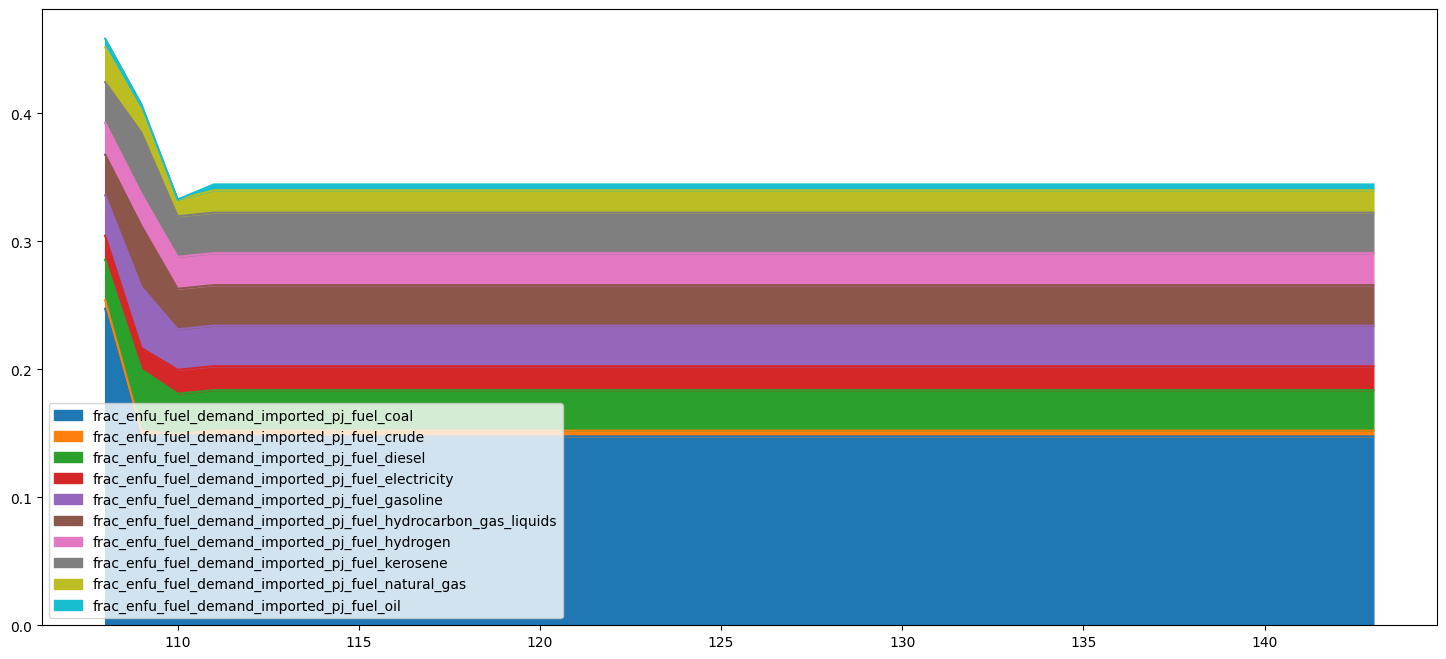

In [205]:
df = df_in_plot
fields = [x for x in df.columns if ("enfu" in x) and ("import" in x)]
fields = [x for x in fields if df[x].max() > 0.00001]

fig, ax = plt.subplots(figsize = (18, 8))
df[fields].plot.area(ax = ax)

In [155]:
#df_in_plot[[x for x in df_in_plot.columns if ("enfu" in x) and ("export" in x)]]
fields = [x for x in df_in_plot.columns if ("trns" in x) and ("kerosene" in x)]
df_in_plot[fields].iloc[25:28]


,ef_trns_mobile_combustion_aviation_kg_ch4_per_tj_kerosene,ef_trns_mobile_combustion_aviation_kg_n2o_per_tj_kerosene,frac_trns_fuelmix_aviation_kerosene,fuelefficiency_trns_aviation_kerosene_km_per_litre
133,0.5,2.0,1.0,0.099687
134,0.5,2.0,1.0,0.100594
135,0.5,2.0,1.0,0.101500


In [121]:
series = df_plot[[x for x in df_plot.columns if ("emission" in x) and ("entc" in x)]].iloc[26]
dict_26 = series.to_dict()

df_26 = (
    pd.DataFrame(dict((k, [v]) for k, v in dict_26.items()))
    .transpose()
    .reset_index()
    .sort_values(by = [0], ascending = False, )
)
df_26.to_csv("/Users/usuario/Desktop/temp.csv", index = None, encoding = "UTF-8",)

# Export Wide File

In [355]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)





# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    ssp.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

<Axes: >

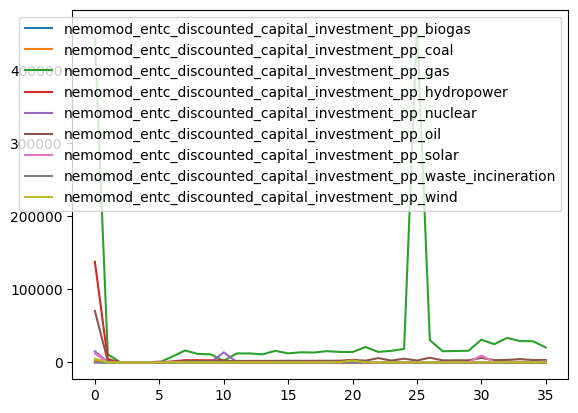

In [43]:
primary_id = 0

df_prim = df_out[
    df_out[
        ssp.key_primary
    ]
    .isin([primary_id])
]

df_in_cur = df_in[
    df_in[
        ssp.key_primary
    ]
    .isin([primary_id])
]


fields_plot = [
    x for x in df_prim.columns
    if "investment" in x
    and df_prim[x].max() > 0
]
(
    df_prim[fields_plot]
    .plot(
        legend = True,
    )
)




<Axes: >

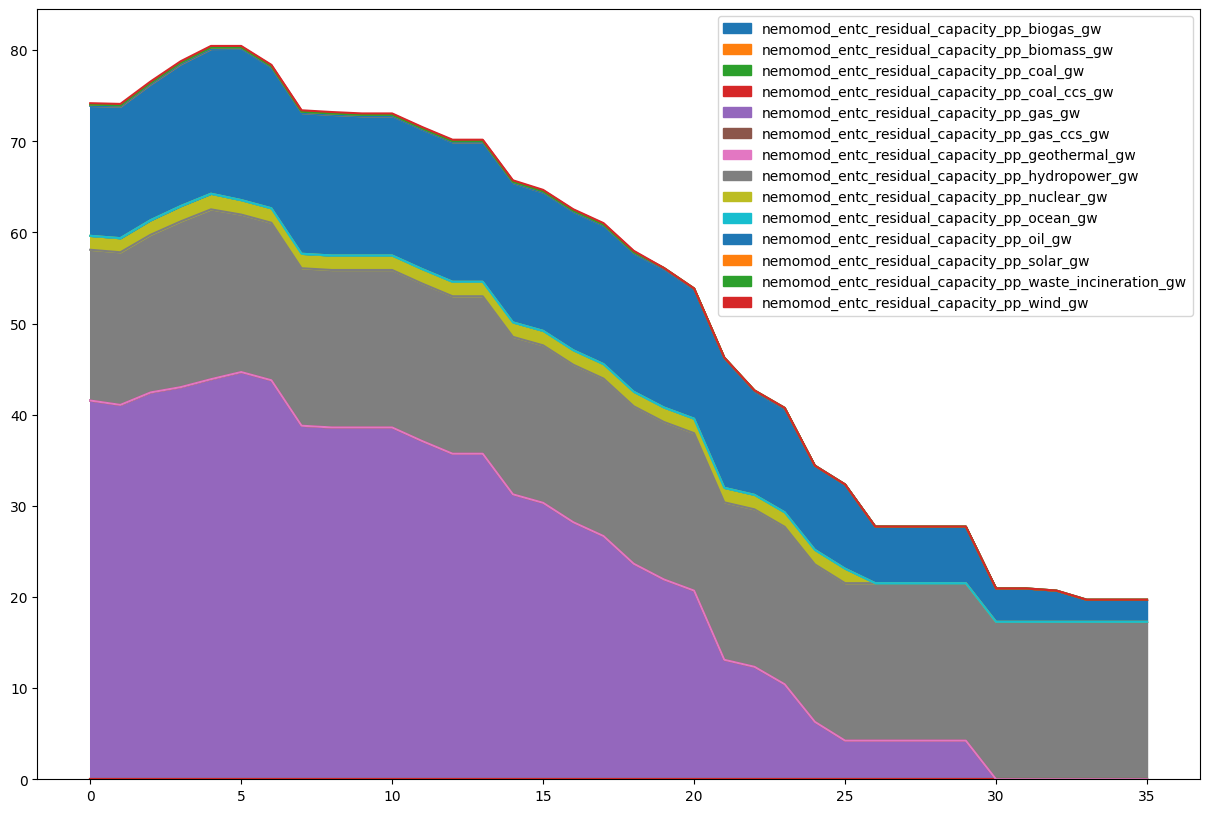

In [208]:


fig, ax = plt.subplots(figsize = (15, 10))
df_resid = matt.extract_model_variable(
    df_in_cur,
    "NemoMod ResidualCapacity"
)
(
    df_resid
    .plot
    .area(
        ax = ax
    )
)

In [336]:
df_resid

,nemomod_entc_residual_capacity_pp_biogas_gw,nemomod_entc_residual_capacity_pp_biomass_gw,nemomod_entc_residual_capacity_pp_coal_gw,nemomod_entc_residual_capacity_pp_coal_ccs_gw,nemomod_entc_residual_capacity_pp_gas_gw,nemomod_entc_residual_capacity_pp_gas_ccs_gw,nemomod_entc_residual_capacity_pp_geothermal_gw,nemomod_entc_residual_capacity_pp_hydropower_gw,nemomod_entc_residual_capacity_pp_nuclear_gw,nemomod_entc_residual_capacity_pp_ocean_gw,nemomod_entc_residual_capacity_pp_oil_gw,nemomod_entc_residual_capacity_pp_solar_gw,nemomod_entc_residual_capacity_pp_waste_incineration_gw,nemomod_entc_residual_capacity_pp_wind_gw
0,0.0,0.0,0.0,0.0,41.559860,0.0,0.0,16.542703,1.529961,0.0,14.260154,0.139226,0.0,0.152996
1,0.0,0.0,0.0,0.0,41.082501,0.0,0.0,16.744743,1.548647,0.0,14.434317,0.140927,0.0,0.154865
2,0.0,0.0,0.0,0.0,42.447927,0.0,0.0,17.301274,1.600118,0.0,14.914059,0.145611,0.0,0.160012
3,0.0,0.0,0.0,0.0,43.030449,0.0,0.0,18.188691,1.682191,0.0,15.571370,0.153079,0.0,0.168219
4,0.0,0.0,0.0,0.0,43.901919,0.0,0.0,18.634288,1.716260,0.0,15.886728,0.156180,0.0,0.171626
5,0.0,0.0,0.0,0.0,44.685942,0.0,0.0,17.277790,1.591323,0.0,16.608002,0.144810,0.0,0.159132
6,0.0,0.0,0.0,0.0,43.786845,0.0,0.0,17.277790,1.591323,0.0,15.436788,0.144810,0.0,0.159132
7,0.0,0.0,0.0,0.0,38.796456,0.0,0.0,17.277790,1.591323,0.0,15.436788,0.144810,0.0,0.159132
8,0.0,0.0,0.0,0.0,38.605497,0.0,0.0,17.277790,1.591323,0.0,15.436788,0.144810,0.0,0.159132
9,0.0,0.0,0.0,0.0,38.605497,0.0,0.0,17.277790,1.591323,0.0,15.282430,0.144810,0.0,0.159132


In [45]:
[x for x in df_out.columns if "capacity" in x]

['nemomod_entc_total_annual_generation_capacity_pp_biogas',
 'nemomod_entc_total_annual_generation_capacity_pp_biomass',
 'nemomod_entc_total_annual_generation_capacity_pp_coal',
 'nemomod_entc_total_annual_generation_capacity_pp_coal_ccs',
 'nemomod_entc_total_annual_generation_capacity_pp_gas',
 'nemomod_entc_total_annual_generation_capacity_pp_gas_ccs',
 'nemomod_entc_total_annual_generation_capacity_pp_geothermal',
 'nemomod_entc_total_annual_generation_capacity_pp_hydropower',
 'nemomod_entc_total_annual_generation_capacity_pp_nuclear',
 'nemomod_entc_total_annual_generation_capacity_pp_ocean',
 'nemomod_entc_total_annual_generation_capacity_pp_oil',
 'nemomod_entc_total_annual_generation_capacity_pp_solar',
 'nemomod_entc_total_annual_generation_capacity_pp_waste_incineration',
 'nemomod_entc_total_annual_generation_capacity_pp_wind',
 'nemomod_entc_total_annual_generation_capacity_st_batteries',
 'nemomod_entc_total_annual_generation_capacity_st_compressed_air',
 'nemomod_entc_t

In [46]:
ssp.model_attributes.configuration.dict_config


{'area_units': 'ha',
 'days_per_year': 365.25,
 'discount_rate': 0,
 'emissions_mass': 'MT',
 'energy_units': 'PJ',
 'energy_units_nemomod': 'PJ',
 'global_warming_potential': 100,
 'historical_back_proj_n_periods': 10,
 'historical_harvested_wood_products_method': 'back_project',
 'historical_solid_waste_method': 'back_project',
 'land_use_reallocation_max_out_directionality': 'decrease_only',
 'length_units': 'km',
 'monetary_units': 'mm_usd',
 'nemomod_solver': 'highs',
 'nemomod_solver_time_limit_seconds': 900,
 'nemomod_time_periods': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 'power_units': 'GW',
 'region': ['costa_rica'],
 'volume_units': 'm3',
 'num_lhc_samples': 1000,
 'output_method': 'sqlite',
 'random_seed': 6401745,
 'save_inputs': False,
 'time_period_u0': 5}

In [47]:
modvar = matt.get_variable("NemoMod Generation Capacity")
modvar.get_from_dataframe(df_prim).head()

,nemomod_entc_total_annual_generation_capacity_pp_biogas,nemomod_entc_total_annual_generation_capacity_pp_biomass,nemomod_entc_total_annual_generation_capacity_pp_coal,nemomod_entc_total_annual_generation_capacity_pp_coal_ccs,nemomod_entc_total_annual_generation_capacity_pp_gas,nemomod_entc_total_annual_generation_capacity_pp_gas_ccs,nemomod_entc_total_annual_generation_capacity_pp_geothermal,nemomod_entc_total_annual_generation_capacity_pp_hydropower,nemomod_entc_total_annual_generation_capacity_pp_nuclear,nemomod_entc_total_annual_generation_capacity_pp_ocean,nemomod_entc_total_annual_generation_capacity_pp_oil,nemomod_entc_total_annual_generation_capacity_pp_solar,nemomod_entc_total_annual_generation_capacity_pp_waste_incineration,nemomod_entc_total_annual_generation_capacity_pp_wind,nemomod_entc_total_annual_generation_capacity_st_batteries,nemomod_entc_total_annual_generation_capacity_st_compressed_air,nemomod_entc_total_annual_generation_capacity_st_flywheels,nemomod_entc_total_annual_generation_capacity_st_pumped_hydro
0,0.000000,0.0,1.038856,0.0,476.773604,0.0,0.0,42.581621,5.315262,0.0,72.847998,17.184417,0.000000,1.642748,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
1,0.000000,0.0,1.068701,0.0,487.343129,0.0,0.0,43.666195,5.454035,0.0,74.688579,17.212680,0.000000,1.684590,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
2,0.005914,0.0,1.068701,0.0,488.708554,0.0,0.0,44.222727,5.505506,0.0,75.168321,17.217364,0.000814,1.689737,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
3,0.012365,0.0,1.068701,0.0,489.291076,0.0,0.0,45.110144,5.587579,0.0,75.825632,17.224833,0.001636,1.697944,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
4,0.019270,0.0,1.068701,0.0,490.162546,0.0,0.0,45.555740,5.621648,0.0,76.140990,17.227933,0.002463,1.701351,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


In [374]:
#[x for x in matt.all_variables if "Consumption" in x]
[x for x in matt.all_variables if "Production" in x]
modvar = matt.get_variable("NemoMod Production by Technology")


unit = matt.get_unit("energy")
(modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

4.446183735851677

In [ ]:
df_inputs

In [57]:
modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
matt.extract_model_variable(
    df_prim,
    modvar
)

,energy_consumption_inen_total
0,1614.348152
1,1605.489146
2,1591.310577
3,1593.633404
4,1593.678415
5,1584.859258
6,1600.060008
7,1656.800166
8,1676.693044
9,1696.331352


In [81]:
ssp.analysis_id

In [74]:
dir(ssp.database.db)
#idb_strat = ssp.database.db.dict_iterative_database_tables.get("ATTRIBUTE_STRATEGY")
#idb_strat.read_table()
ssp.database.db.read_table("ATTRIBUTE_STRATEGY")

ssp.database.db.fp_base_output



'/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-04T09;23;26.721580/sisepuede_run_2024-11-04T09;23;26.721580_output_database'

In [69]:
idb_strat.read_table()

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:CONSTRAINED,Constrained Climate Action,NaN,TX:AGRC:DEC_CH4_RICE_LOW|TX:AGRC:DEC_LOSSES_SU...,0
70,6004,PFLO:TECHNOLOGICAL_ADOPTION,Technology Adoption Scenario,NaN,TX:AGRC:DEC_CH4_RICE_LOW|TX:AGRC:DEC_LOSSES_SU...,0
